# Lab #2

In [1]:
import numpy as np
import pandas
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import operator
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
%matplotlib inline

Загрузим данные и разобьем их на тренировочную и тестовую выборки образом случайным в отношении 1:3:

In [20]:
with open('blogData_train.csv') as input_file:
    data = []
    for line in input_file:
        line = line.split(',')
        line = [float(item) for item in line]
        data.append(np.array(line))
data = np.array(data)

X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.75)

## Пункты 1-3 для RandomForestRegressor

Обучим RandomForestRegressor на тренировочной выборке и для количеств деревьев от 1 до 250 посчитаем ошибку out-of-bag, на тренировочной и тестовой выборках:

In [171]:
def process_rfr(rfr, n_estimators):
    forest_errors_train = []
    forest_errors_test = []
    oob_train_score_mse = []
    
    for i in range(1, n_estimators+1):
        rfr = rfr.set_params(n_estimators=i)
        rfr.fit(X_train, y_train)

        # train sample mse error
        forest_errors_train.append(mean_squared_error(rfr.predict(X_train), y_train))

        # mse of train sample oob and y_train 
        oob_train_score_mse.append(mean_squared_error(rfr.oob_prediction_, y_train))

        # test sample mse error
        forest_errors_test.append(mean_squared_error(rfr.predict(X_test), y_test))
        
    return forest_errors_train, forest_errors_test, oob_train_score_mse


rfr = RandomForestRegressor(oob_score=True, warm_start=True)        
forest_errors_train, forest_errors_test, oob_train_score_mse = process_rfr(rfr, 250)

Графики зависимости ошибки от количества деревьев в композиции:

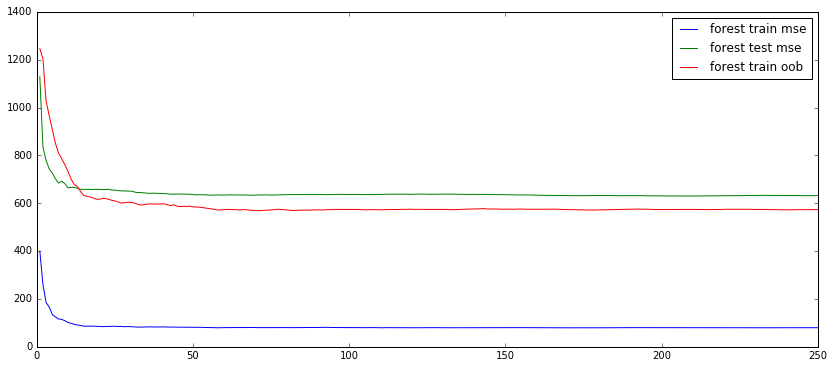

In [148]:
plt.figure(figsize=(14,6))
plt.plot(range(1, 251), forest_errors_train, label='forest train mse')
plt.plot(range(1, 251), forest_errors_test, label='forest test mse')

plt.plot(range(1, 251), oob_train_score_mse, label='forest train oob ')
plt.legend(loc=1)

plt.show()


### Выводы:
Из графика видно, что при количестве деревьев, большем ~80, ошибки out-of-bag и mse на тесте перестают изменяться. При этом ошибка out-of-bag совсем немного меньше ошибки на тесте. Можно сдеать вывод, что random forest не переобучается при большом количестве деревьев и качество его работы можно оценивать, используя только train выборку (с помощью out-of-bag)

График распределения важности признаков:

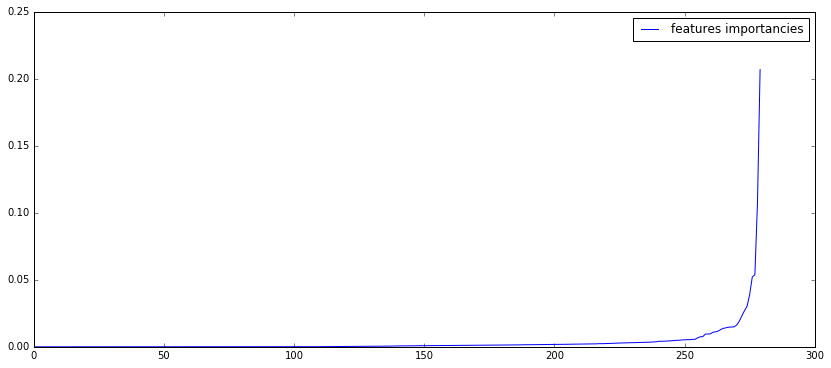

In [67]:
def show_feature_importances(feature_importances):
    plt.figure(figsize=(14,6))
    plt.plot(range(len(feature_importances)), sorted(feature_importances), label='features importancies')
    plt.legend(loc=1)

    plt.show()
    
show_feature_importances(rfr.feature_importances_)

Функция для выделения главных признаков:

In [93]:
def get_important_features(feature_importances):
    features = {}
    for i, x in enumerate(feature_importances):
        features[i] = x

    sorted_features_list = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
    
    sorted_features_indices = [sorted_features_list[i][0] for i in range(len(sorted_features_list))]
    sorted_features = [sorted_features_list[i][1] for i in range(len(sorted_features_list))]
    
    important_features = []
    important_features_indices = []
    
    for index in range(len(sorted_features)):
        important_features.append(sorted_features[index])
        important_features_indices.append(sorted_features_indices[index])
        
        if sum(important_features) > 0.95 * sum(sorted_features):
            break
    return important_features_indices
        
important_features_indices_rfr = get_important_features(rfr.feature_importances_)

Создаем сет важных признаков: 

In [177]:
X_train_less_features_rfr = X_train[:,important_features_indices_rfr]
X_test_less_features_rfr = X_test[:,important_features_indices_rfr]

Обучим RandomForest на новом множестве признаков и на старом и сравним ошибки на test:

In [153]:
# обучаем random forest на новом множестве признаков
rfr_less_features = RandomForestRegressor(n_estimators=250, oob_score=True, warm_start=True)
rfr_less_features.fit(X_train_less_features_rfr, y_train)

# ошибка mse в зависимости от количества деревьев на новом множестве признаков
forest_errors_test_less_features = []

for i in range(1, 251):
    y_pred_less  = np.mean(np.array([rfr_less_features.estimators_[j].predict(X_test_less_features_rfr)
                                     for j in range(i)]), axis = 0)

    forest_errors_test_less_features.append(mean_squared_error(y_pred_less, y_test))

In [156]:
# обучим RandomForestRegressor с теми же параметрами, что rfr_less_features, но на всем сете признаков
rfr_all_features = RandomForestRegressor(n_estimators=250, oob_score=True, warm_start=True)
rfr_all_features.fit(X_train, y_train)

# ошибка mse в зависимости от количества деревьев на всем множестве признаков
forest_errors_test_all_features = []

for i in range(1, 251):
    y_pred_all  = np.mean(np.array([rfr_all_features.estimators_[j].predict(X_test)
                                     for j in range(i)]), axis = 0)

    forest_errors_test_all_features.append(mean_squared_error(y_pred_all, y_test))

Зависимость ошибки прогноза в зависимости
от количества деревьев для выборки по всем признакам и по выбранным:

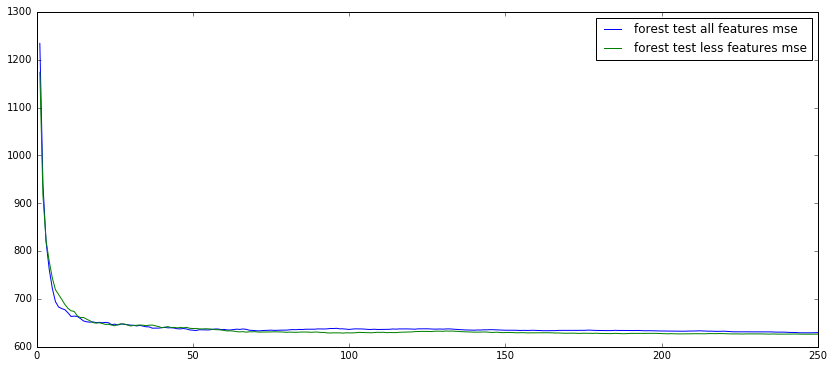

In [157]:
plt.figure(figsize=(14,6))
plt.plot(range(1, 251), forest_errors_test_all_features, label='forest test all features mse')
plt.plot(range(1, 251), forest_errors_test_less_features, label='forest test less features mse')
plt.legend(loc=1)

plt.show()


### Выводы:
Ошибки на тесте при обучении модели на всех признаках и на "важных" совпадают. Значит, для random forest 5% наименее важных признаков не играют роли и для ускорения работы можно их убирать.

Подберем оптимальные значения параметров max_features и min_samples_split:
Для каждой пары (max_features и min_samples_split) из сетки построим график ошибки прогноза на обучающей и на тестовой выборке в зависимости от количества деревьев. Будем для каждой пары параметров искать оптимальный n_estimators: пока разность ошибок на на последней и 10-й с конца итерациях не станет < eps ,будем увеличивать n_estimators. Возьмем eps=1.5

In [17]:
def show_mse_errors(min_samples_split, max_features, n_estimators, train_errors, test_errors):
    plt.figure(figsize=(11,5))
    # graphs for train and test mse errors
    plt.title('split: %s, features: %s, n_estimators: %s' % 
              (min_samples_split, max_features, n_estimators))
    plt.plot(range(len(train_errors)), train_errors, label='train mse')
    plt.plot(range(len(test_errors)), test_errors, label='test mse')

    plt.legend(loc=1)

    plt.show()

In [191]:
def process_clf(clf, Xtrain, ytrain, Xtest, ytest, eps):
    n_estimators = 0
    train_errors = []
    test_errors = []

    while True:
        n_estimators += 1
        clf.set_params(n_estimators=n_estimators)
        clf.fit(Xtrain, ytrain)

        last_error = mean_squared_error(clf.predict(Xtrain), ytrain)

        train_errors.append(mean_squared_error(clf.predict(Xtrain), ytrain))
        test_errors.append(mean_squared_error(clf.predict(Xtest), ytest))

        if len(train_errors) < 11:
            continue

        # see if mistake changed not much through last 10 iterations
        if abs(train_errors[-10] - last_error) > eps:
            continue

        show_mse_errors(min_samples_split, max_features, n_estimators, train_errors, test_errors)

        return n_estimators, train_errors[-1], test_errors[-1]

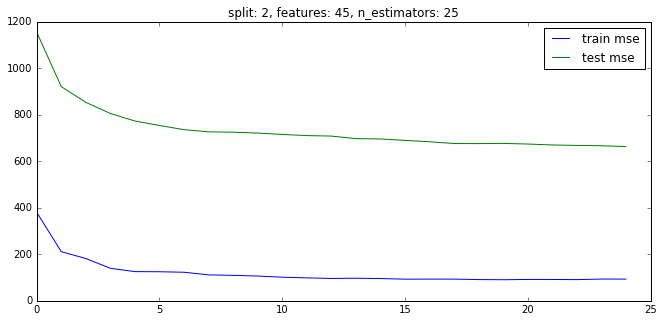

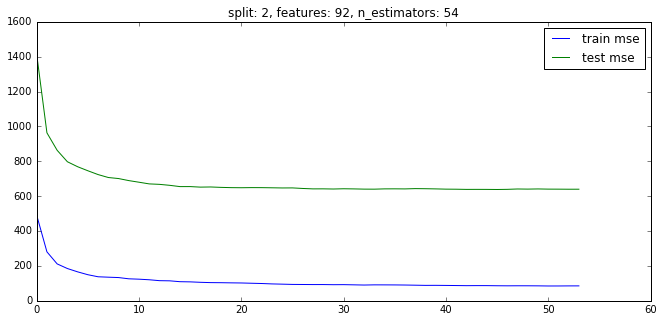

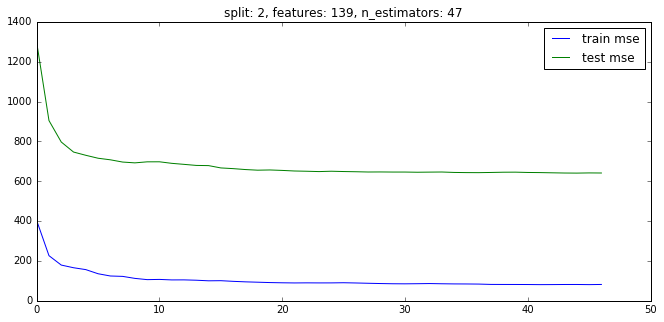

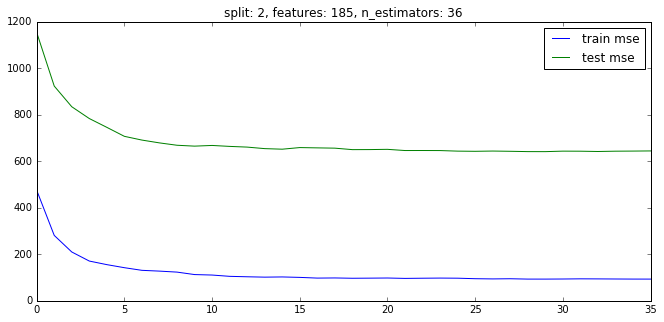

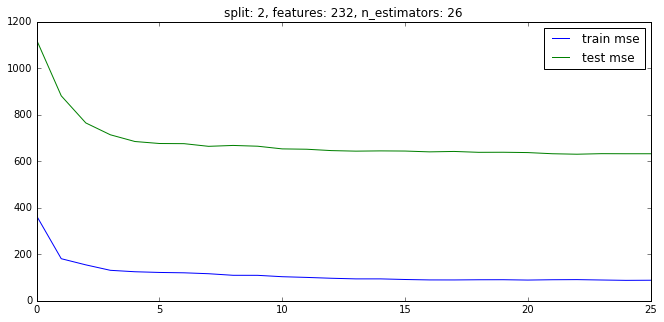

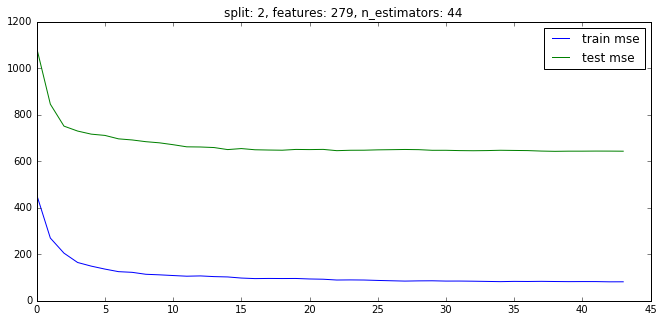

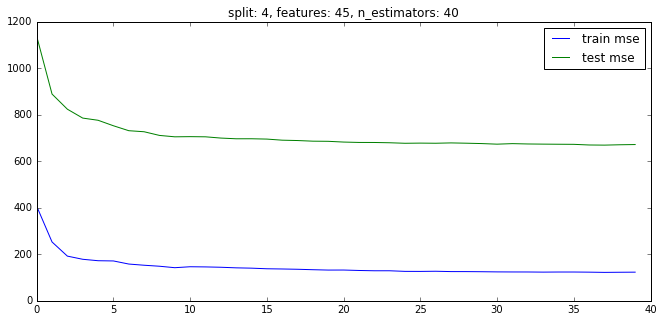

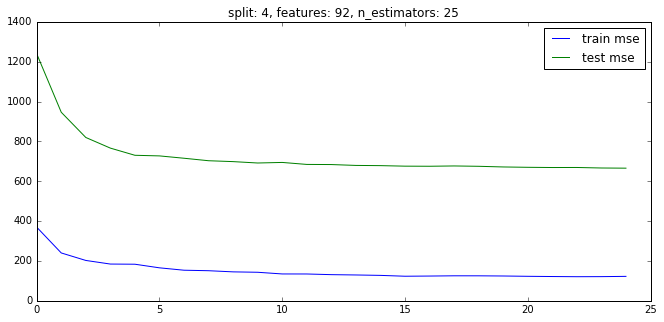

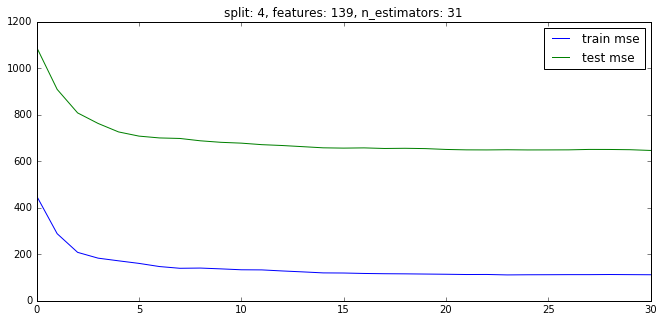

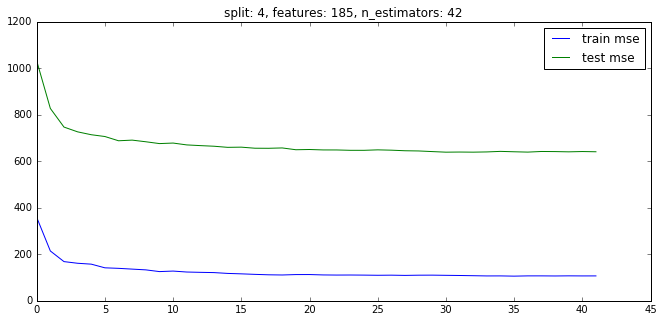

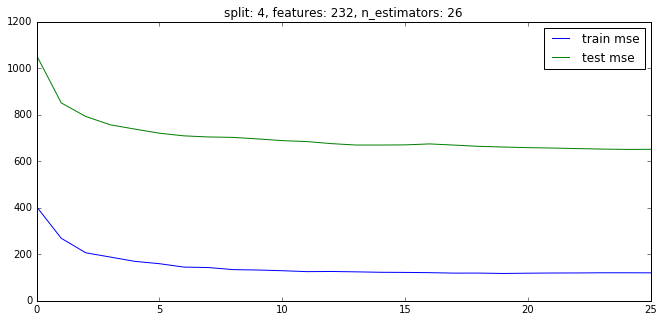

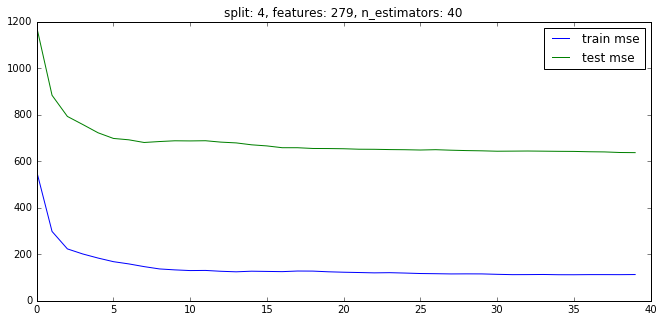

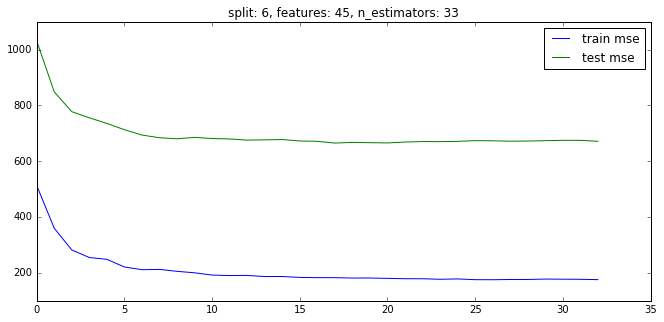

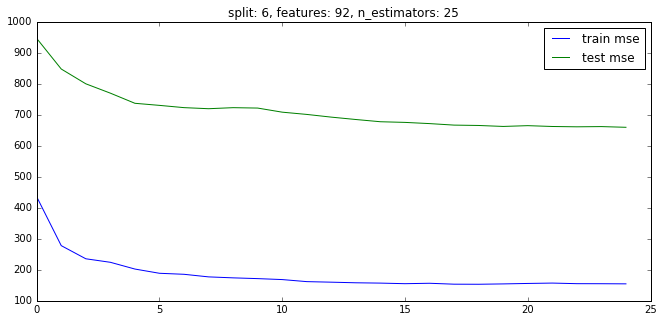

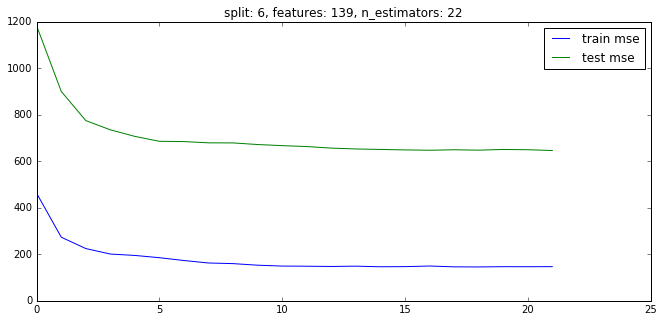

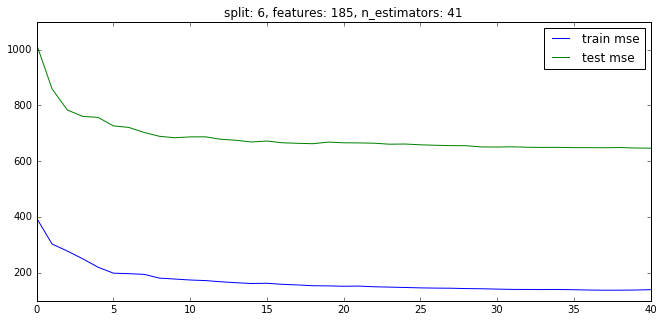

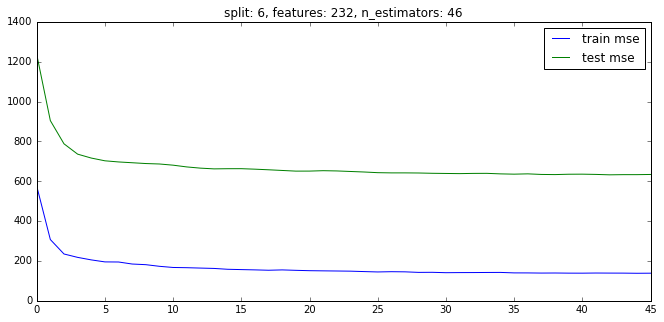

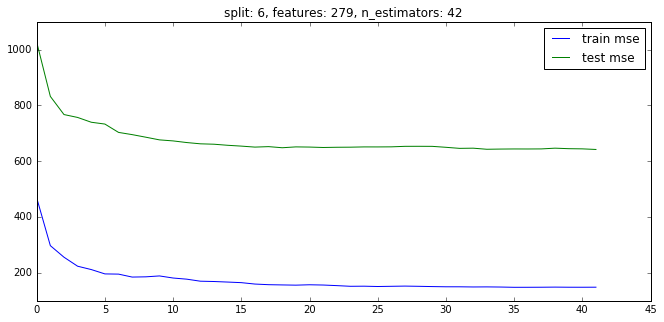

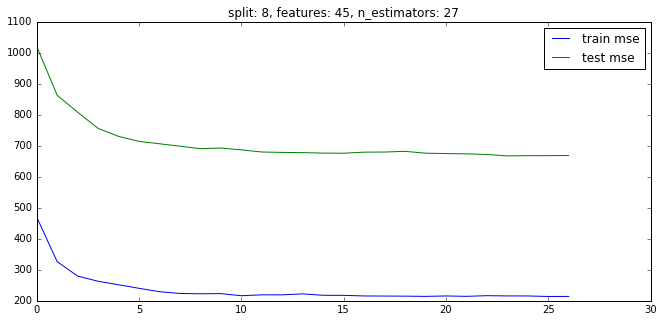

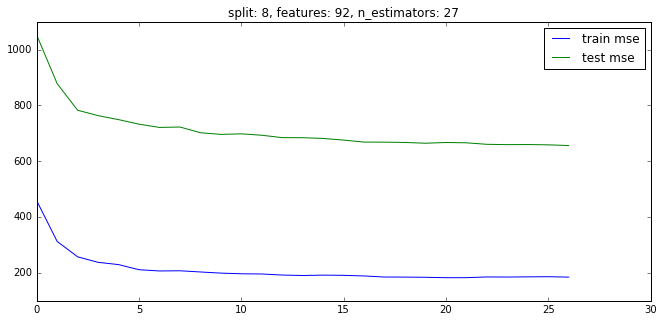

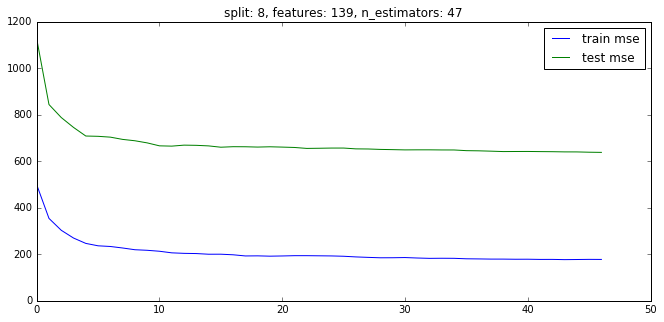

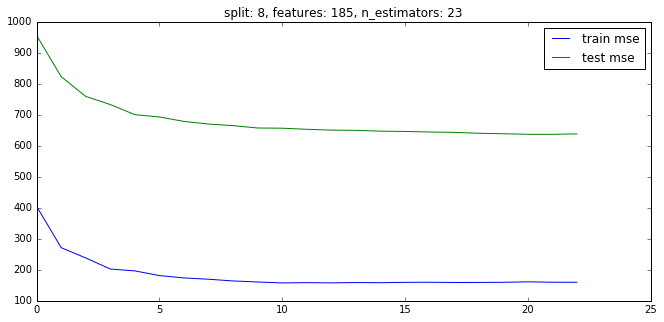

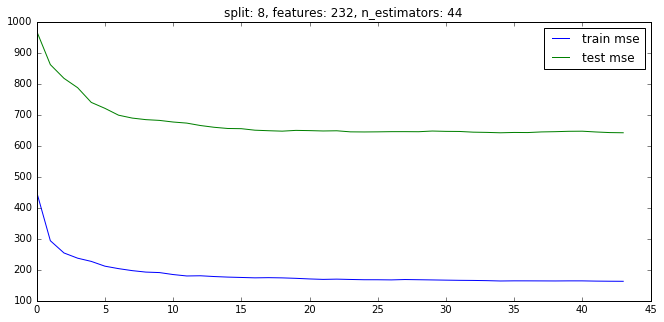

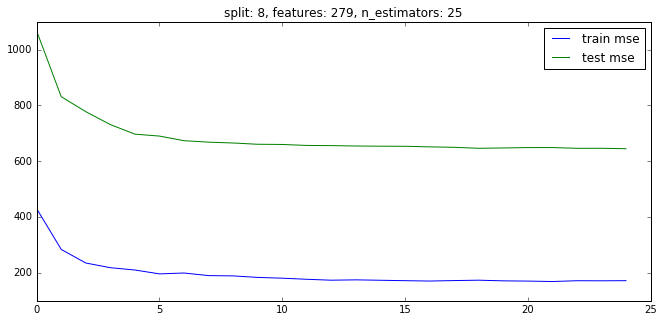

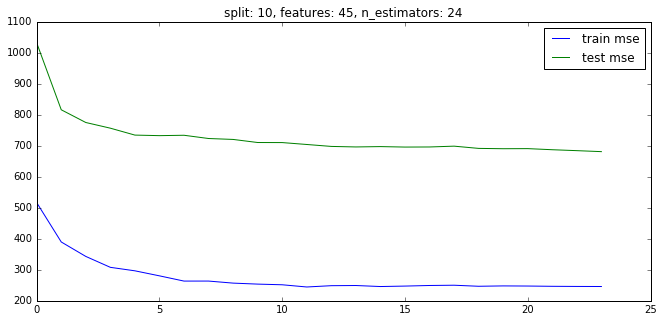

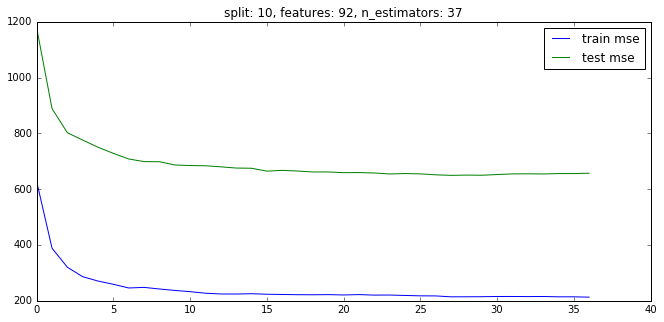

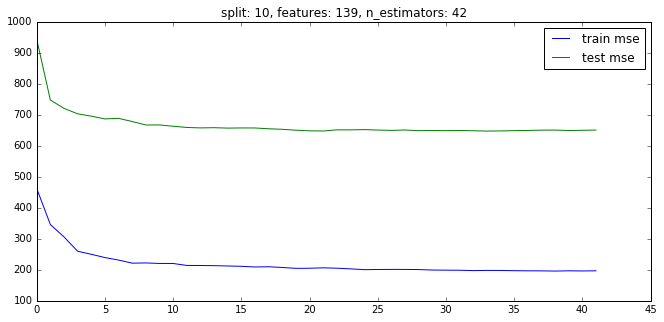

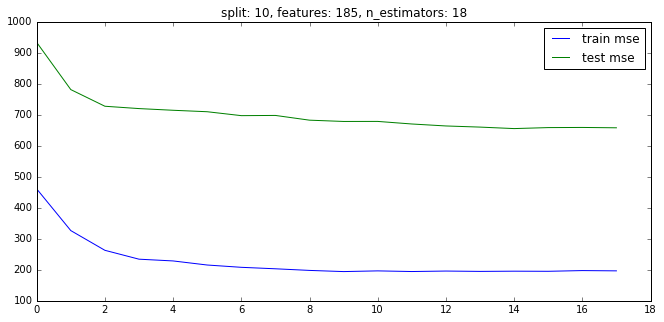

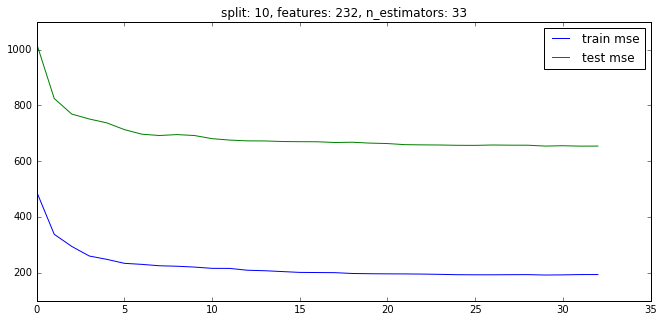

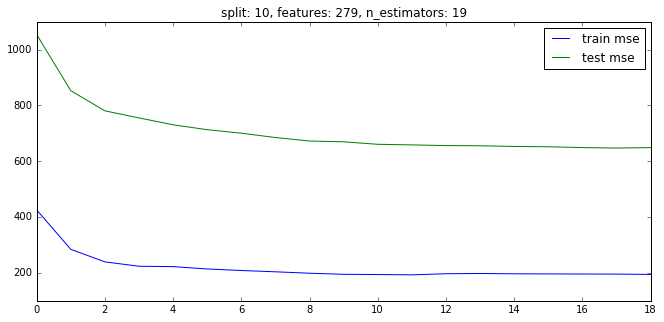

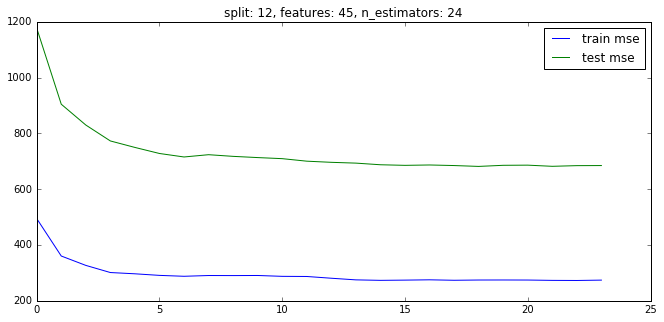

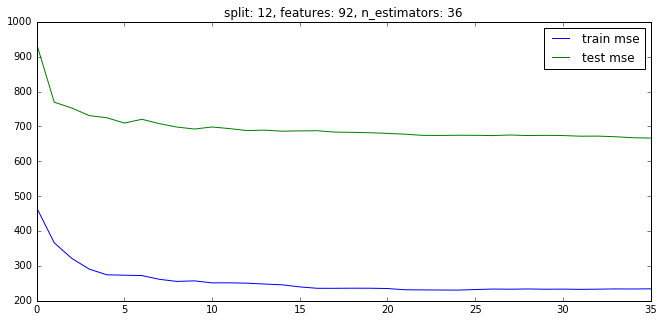

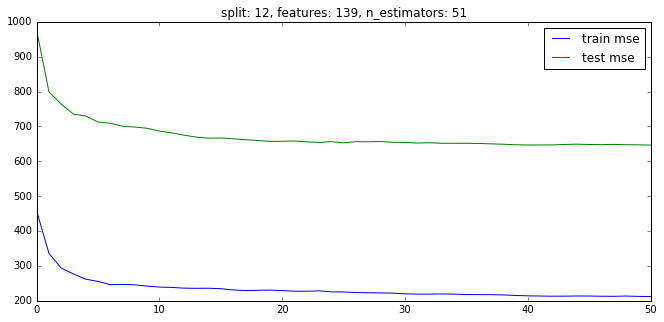

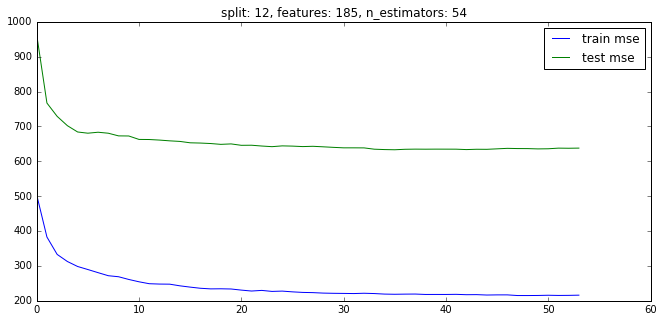

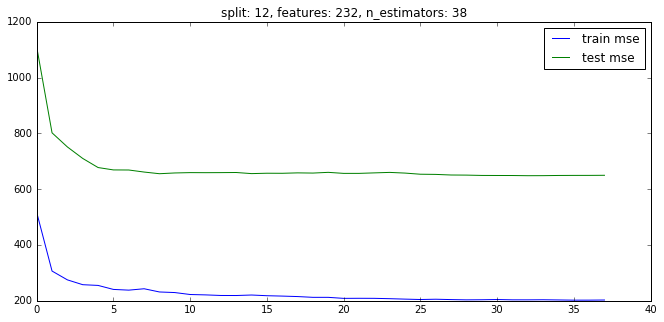

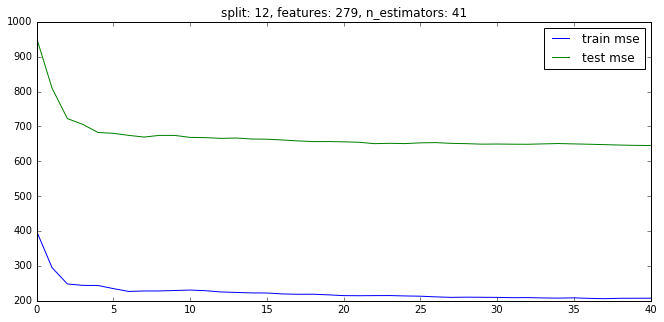

In [193]:
eps = 1.5

optimal_params_rfr = [[0 for i in range(6)] for j in range(6)]
train_error_matrix_rfr = [[0 for i in range(6)] for j in range(6)]
test_error_matrix_rfr = [[0 for i in range(6)] for j in range(6)]

for min_samples_split in [2, 4, 6, 8, 10, 12]:
    for max_features in [int(280.0*i/6)-1 for i in range(1,7)]:
        rfr = RandomForestRegressor(max_features=max_features, min_samples_split=min_samples_split, warm_start=True)
        n_estimators, train_error, test_error = process_clf(rfr, X_train, y_train, X_test, y_test, eps)
        
        optimal_params_rfr[min_samples_split/2 - 1][max_features/40 - 1] = n_estimators
        train_error_matrix_rfr[min_samples_split/2 - 1][max_features/40 - 1] = train_error
        test_error_matrix_rfr[min_samples_split/2 - 1][max_features/40 - 1] = test_error

Визуализируем матрицы ошибок на train и test выборках:

In [195]:
pandas.DataFrame.from_records(test_error_matrix_rfr)

,0,1,2,3,4,5
0,663.101534,639.924750,641.290280,644.594067,632.499048,643.438985
1,672.093760,665.520168,646.670635,641.046282,651.410891,637.286133
2,671.757430,659.671915,646.304628,647.048685,633.948355,642.412360
3,668.653051,656.406456,638.372395,638.420433,642.084623,645.197471
4,681.168432,657.205759,650.699851,658.087800,654.611470,649.128264
5,684.771814,666.593211,646.406509,637.822004,649.837173,645.243471


### Выводы:
Судя по ошибке на тесте, лучшая модель из рассмотренных -- при max_features=232, min_samples_split=2, и при этом n_estimators=26. Однако по матрице ошибок видно, что почти для всех значений max_features, min_samples_split ошибки почти одинаковы. Непонятно, будет и модель с max_features=232, min_samples_split=2 лучшей для других данных. 

Лучшее значение для n_estimators получилось не совпадающим с default'ным для random forest. Значит, для random forest подбор параметров может улучшить результат.

In [3]:
best_features_rfr = 232
best_split_rfr = 2
best_estimators_rfr = 126

Матрицы ошибок на train и test:

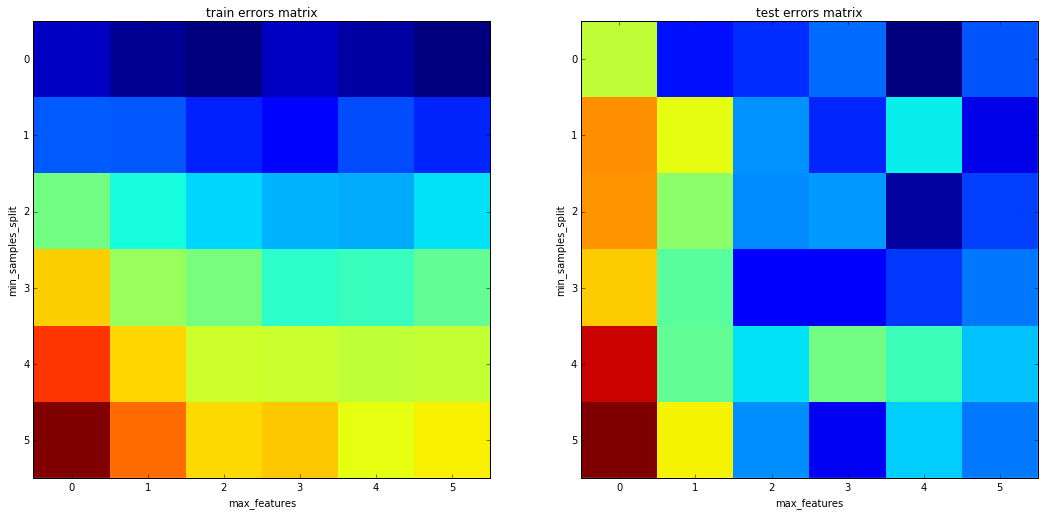

In [197]:
def visualize_matrices(train_error_matrix, test_error_matrix):
    plt.figure(figsize=(18, 10))

    plt.subplot(1, 2, 1)
    plt.title('train errors matrix')
    plt.xlabel('max_features')
    plt.ylabel('min_samples_split')
    plt.imshow(train_error_matrix.as_matrix(), interpolation='none')

    plt.subplot(1, 2, 2)
    plt.title('test errors matrix')
    plt.xlabel('max_features')
    plt.ylabel('min_samples_split')
    plt.imshow(test_error_matrix.as_matrix(), interpolation='none')

    plt.show()
    
visualize_matrices(pandas.DataFrame.from_records(train_error_matrix_rfr), 
                   pandas.DataFrame.from_records(test_error_matrix_rfr))

## Пункты 1-3 для GradientBoostingRegressor

Обучим GradientBoostingRegressor на тренировочной выборке и для количеств деревьев от 1 до 250 посчитаем ошибки на тренировочной и тестовой выборках:

In [172]:
def process_gbr(gbr, n_estimators):
    boosting_errors_train = []
    boosting_errors_test = []
    
    for i in range(1, n_estimators+1):
        gbr = gbr.set_params(n_estimators=i)
        gbr.fit(X_train, y_train)

        # train sample mse error
        boosting_errors_train.append(mean_squared_error(gbr.predict(X_train), y_train))

        # test sample mse error
        boosting_errors_test.append(mean_squared_error(gbr.predict(X_test), y_test))
        
    return boosting_errors_train, boosting_errors_test


gbr = GradientBoostingRegressor(warm_start=True)        
boosting_errors_train, boosting_errors_test = process_gbr(gbr, 250)

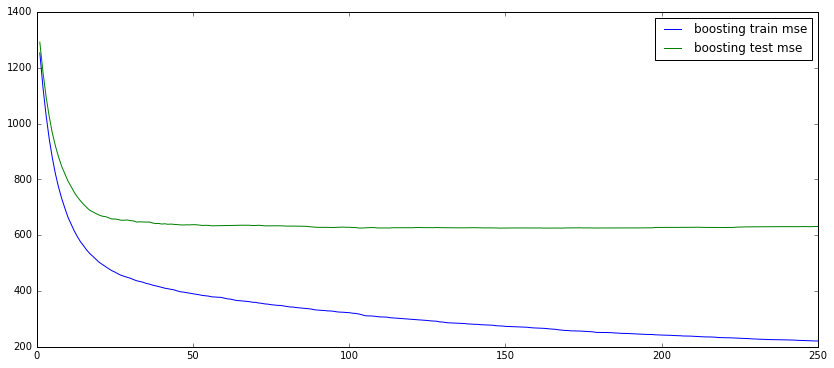

In [59]:
plt.figure(figsize=(14,6))
plt.plot(range(1, 251), boosting_errors_train, label='boosting train mse')
plt.plot(range(1, 251), boosting_errors_test, label='boosting test mse')
plt.legend(loc=1)

plt.show()

### Выводы:
Судя по тому, что при увеличении числа деревьев ошибка на train заметно падает, а на тесте немного растет, то gradient boosting начинает переобучаться при большом количестве деревьев.

График распределения важности признаков:

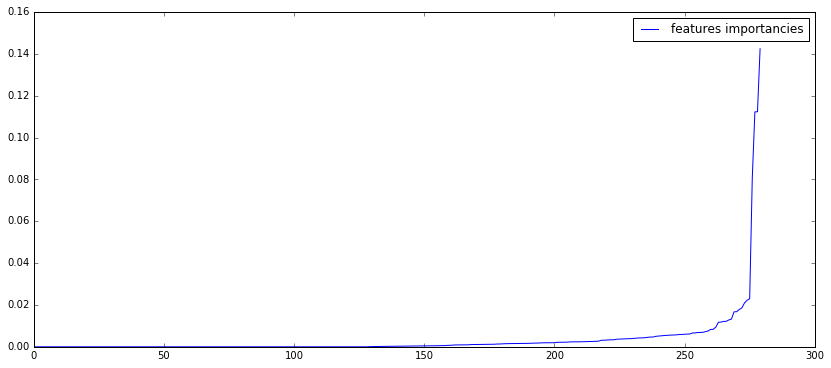

In [202]:
show_feature_importances(gbr.feature_importances_)

In [203]:
important_features_indices_gbr = get_important_features(gbr.feature_importances_)

In [205]:
X_train_less_features_gbr = X_train[:,important_features_indices_gbr].copy(order='C')
X_test_less_features_gbr = X_test[:,important_features_indices_gbr]

In [206]:
# обучаем gradient boosting на новом множестве признаков
gbr_less_features = GradientBoostingRegressor(warm_start=True)

boosting_errors_test_less_features = []

# почитаем ошибку на тестовой выборке для количеств деревьев от 1 до 250
for i in range(1, 251):
    gbr_less_features = gbr_less_features.set_params(n_estimators=i)
    gbr_less_features.fit(X_train_less_features_gbr, y_train)
    
    y_pred_less = gbr_less_features.predict(X_test_less_features_gbr)   
    boosting_errors_test_less_features.append(mean_squared_error(y_pred_less, y_test))

In [209]:
# обучим GradientBoostingRegressor с теми же параметрами, что gbr_less_features, но на всем сете признаков
gbr_all_features = GradientBoostingRegressor(warm_start=True)

# ошибка mse в зависимости от количества деревьев на всем множестве признаков
boosting_errors_test_all_features = []

for i in range(1, 251):
    gbr_all_features = gbr_all_features.set_params(n_estimators=i)
    gbr_all_features.fit(X_train, y_train)
    
    y_pred_all  = gbr_all_features.predict(X_test)   

    boosting_errors_test_all_features.append(mean_squared_error(y_pred_all, y_test))

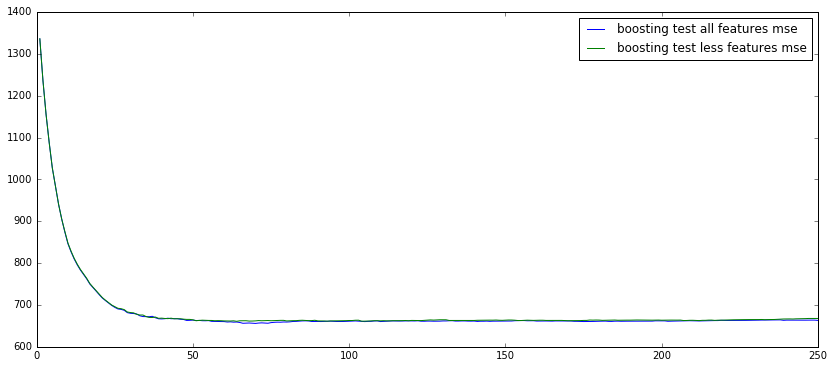

In [210]:
plt.figure(figsize=(14,6))
plt.plot(range(1, 251), boosting_errors_test_all_features, label='boosting test all features mse')
plt.plot(range(1, 251), boosting_errors_test_less_features, label='boosting test less features mse')
plt.legend(loc=1)

plt.show()

### Выводы:
Здесь то же самое, что для random forest -- неважные признаки можно убрать

Подберем оптимальные значения параметров max_features и min_samples_split: Для каждой пары (max_features и min_samples_split) из сетки построим график ошибки прогноза на обучающей и на тестовой выборке в зависимости от количества деревьев. Для каждой пары (max_features и min_samples_split) из сетки построим график ошибки прогноза на обучающей и на тестовой выборке в зависимости от количества деревьев. Будем для каждой пары параметров искать оптимальный n_estimators: пока разность ошибок на на последней и 10-й с конца итерациях не станет < eps ,будем увеличивать n_estimators. Возьмем eps=7.

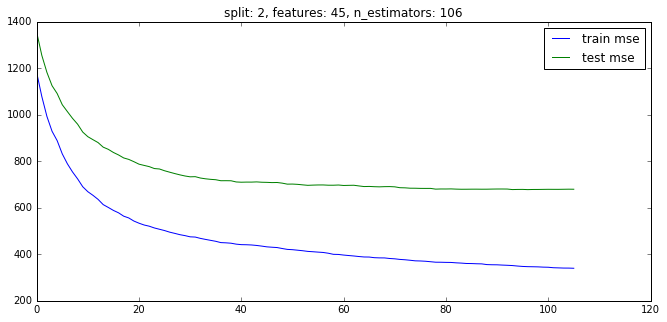

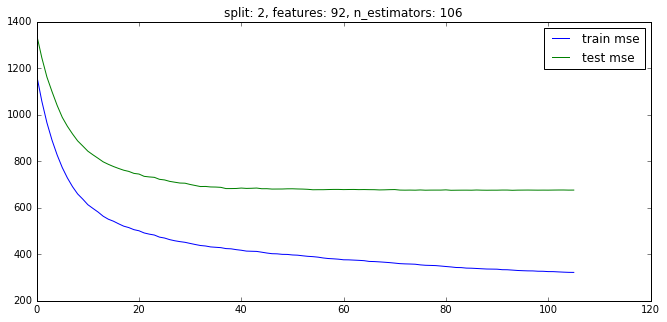

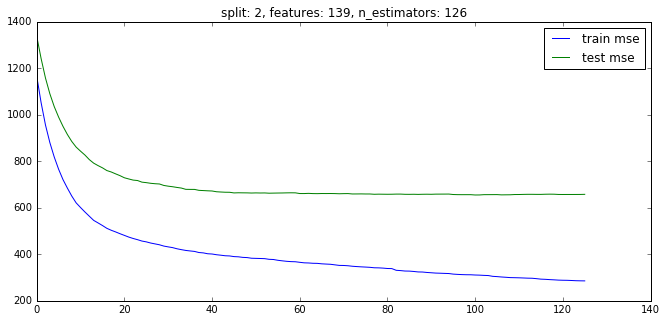

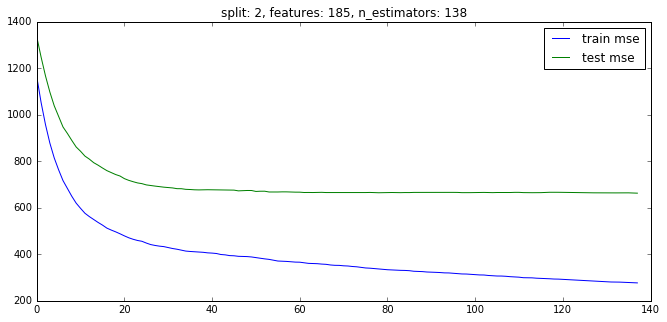

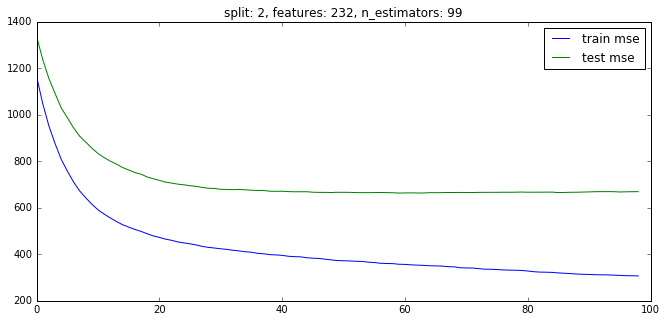

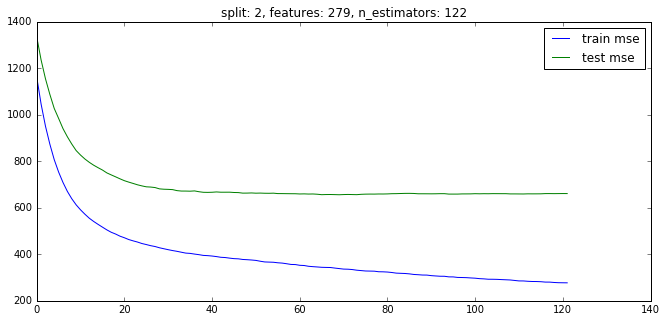

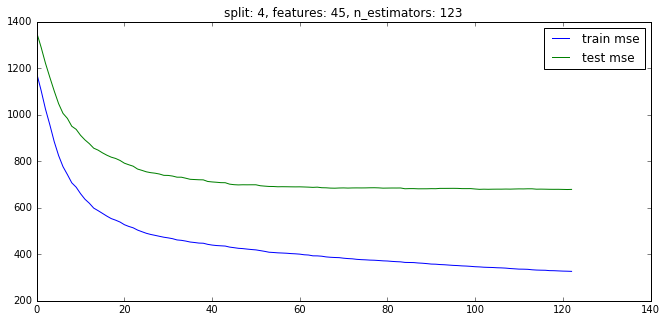

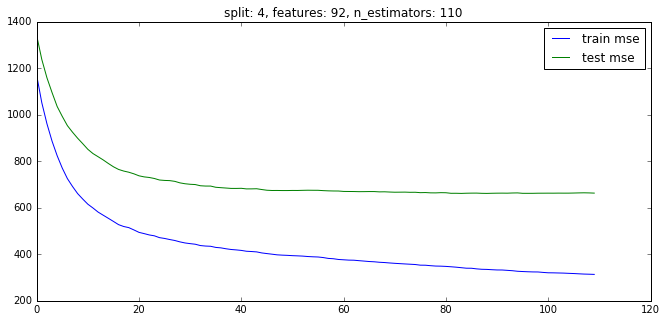

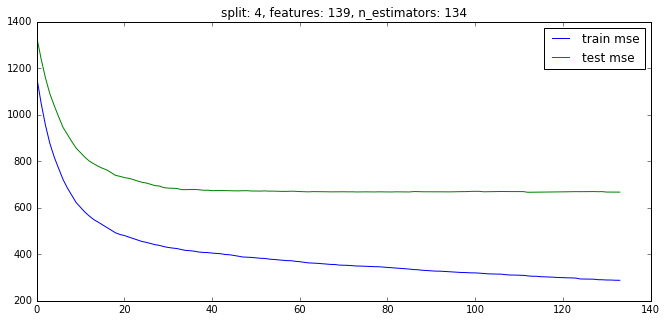

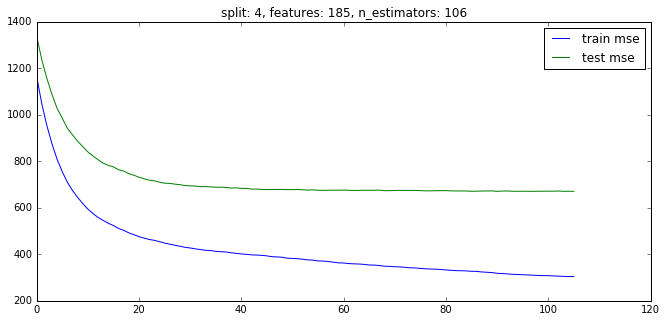

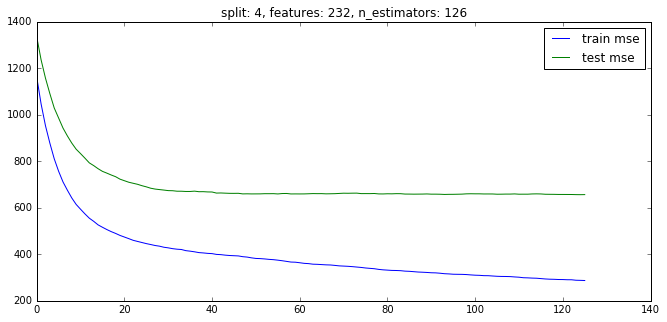

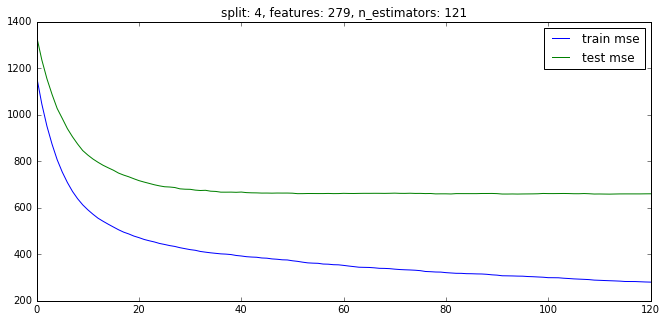

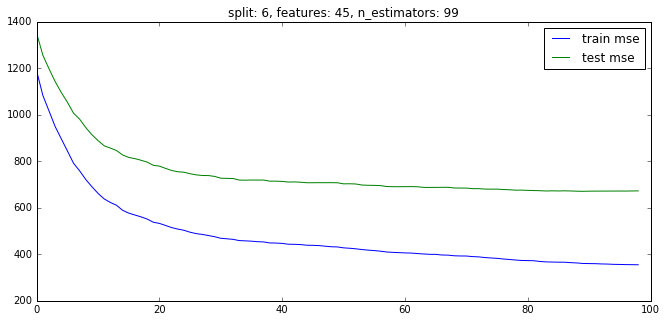

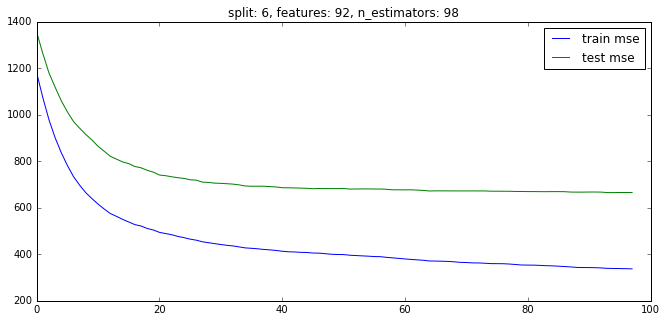

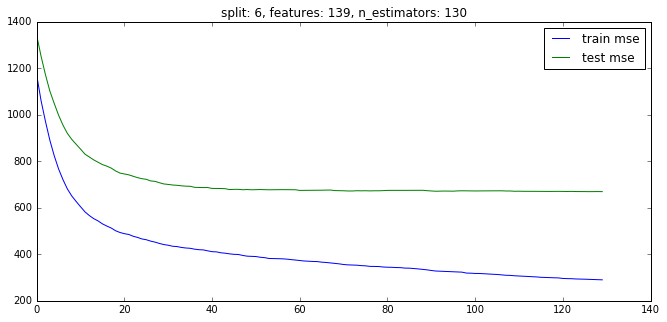

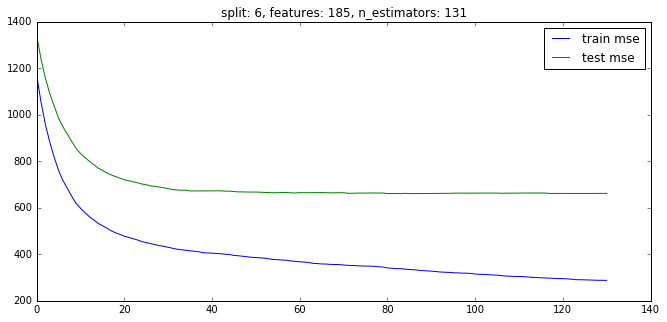

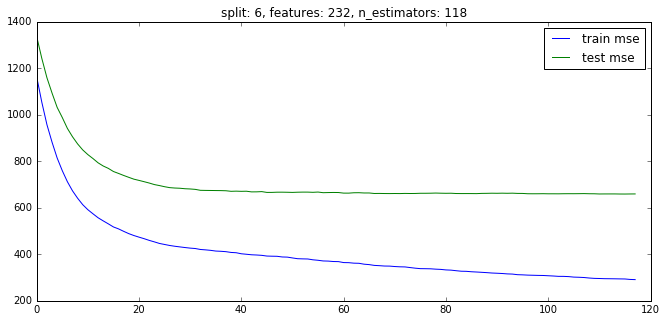

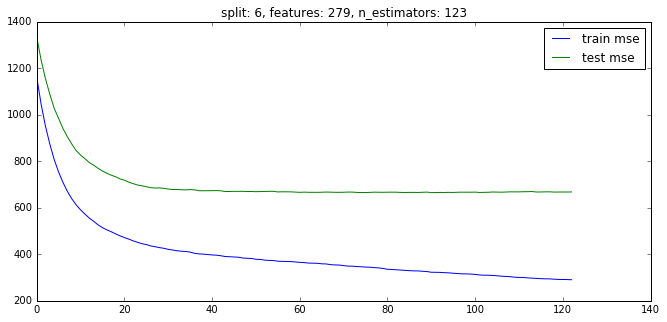

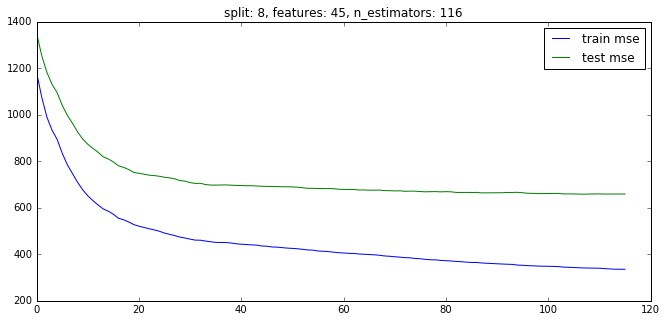

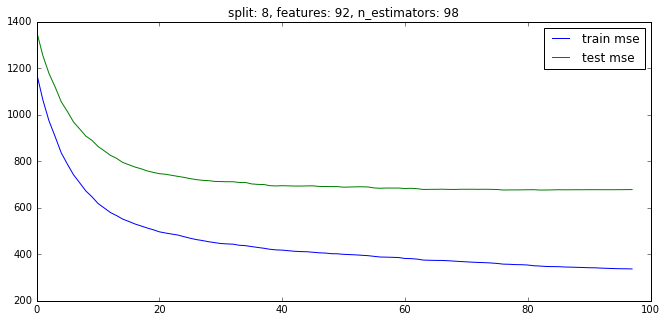

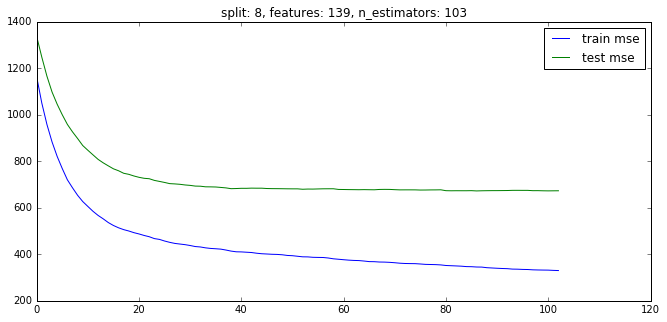

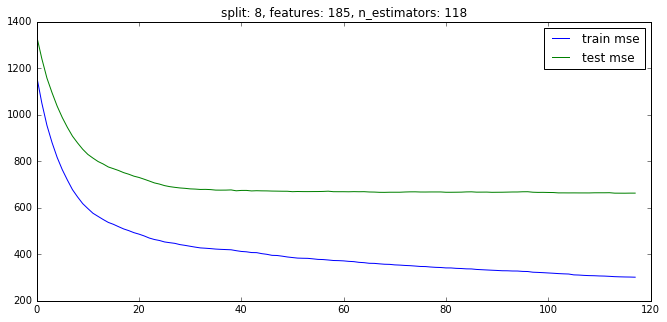

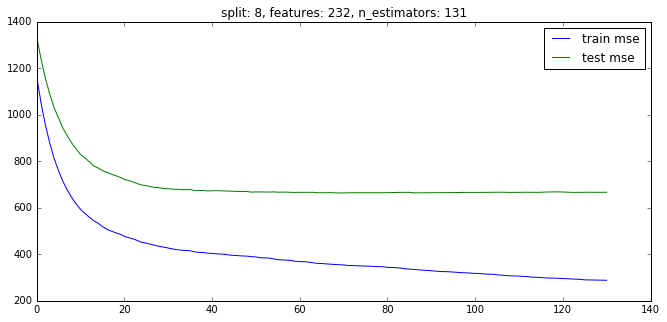

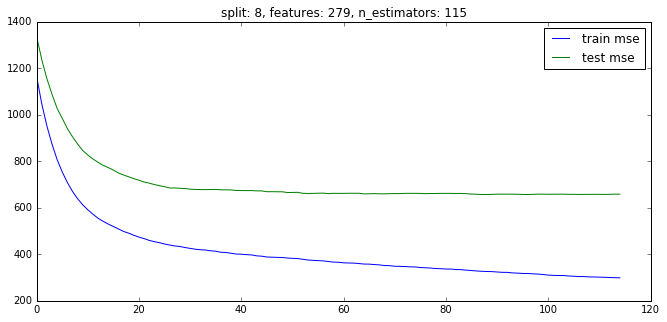

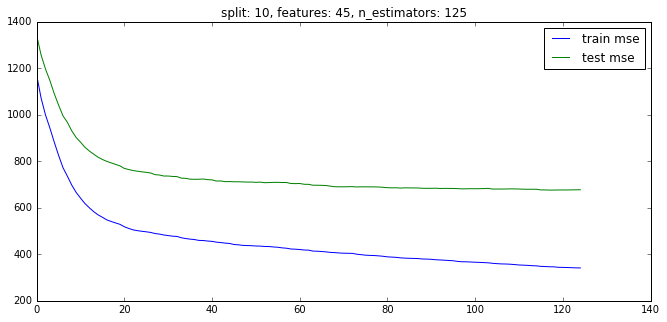

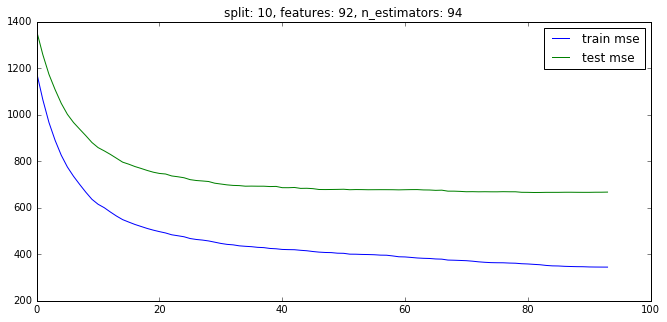

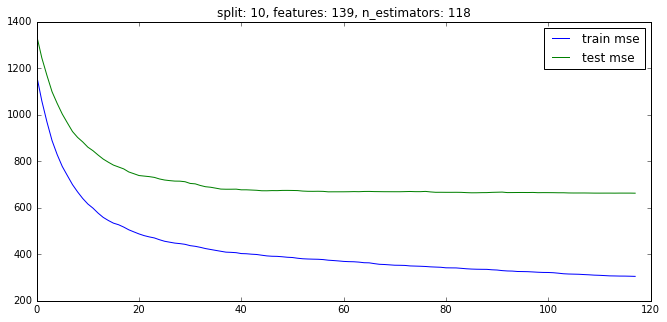

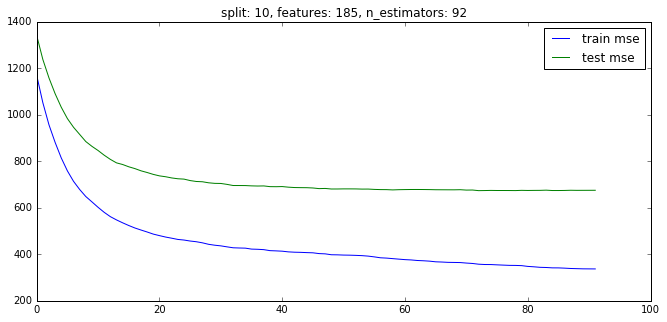

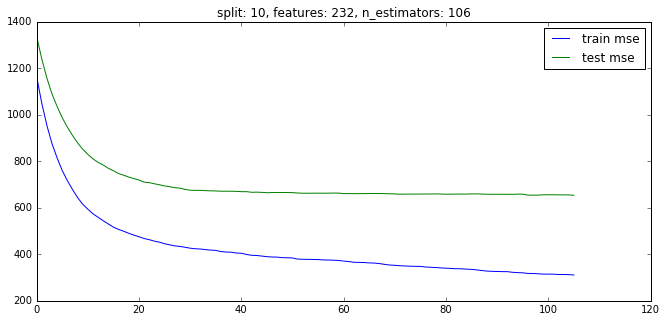

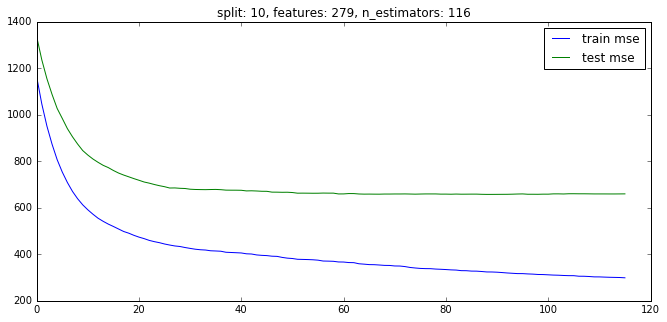

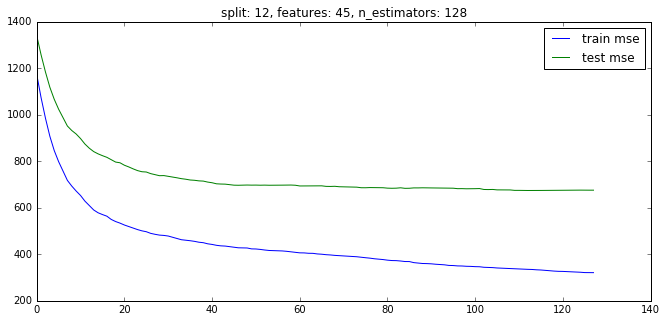

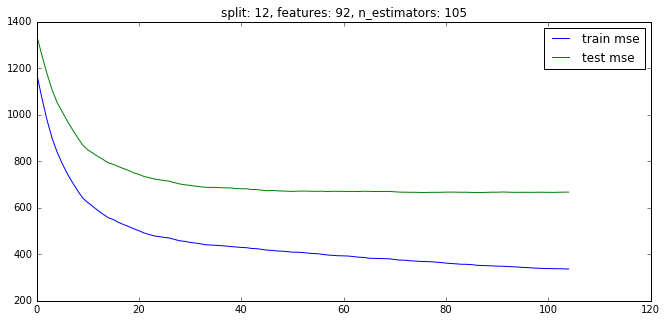

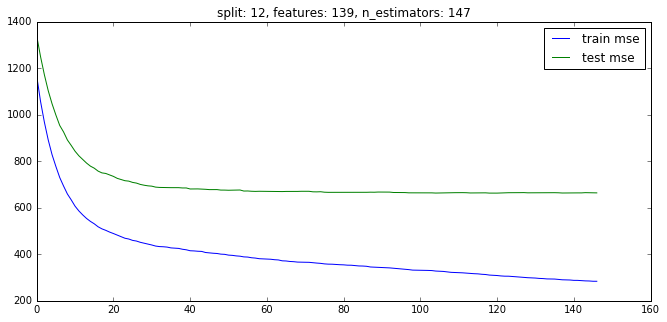

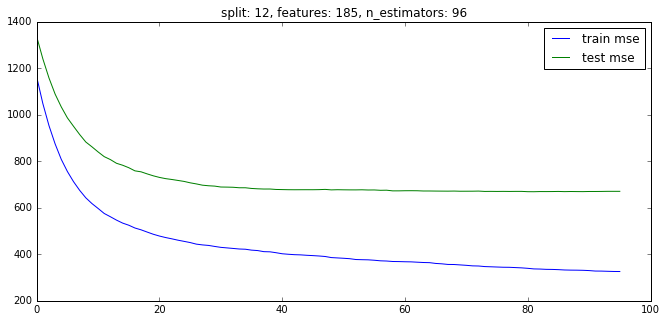

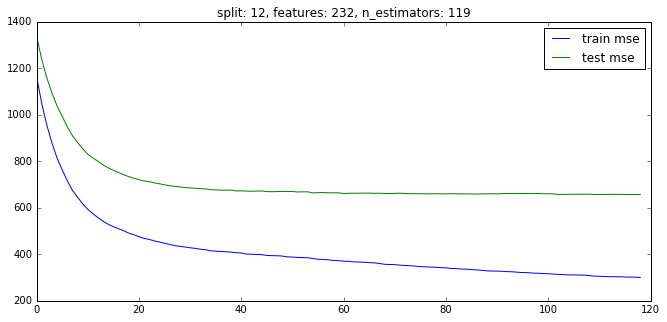

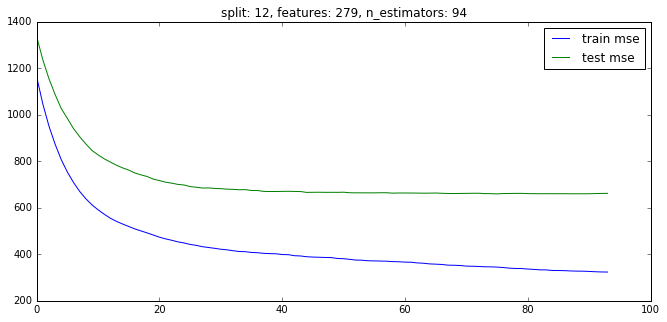

In [213]:
eps = 7

optimal_params_gbr = [[0 for i in range(6)] for j in range(6)]
train_error_matrix_gbr = [[0 for i in range(6)] for j in range(6)]
test_error_matrix_gbr = [[0 for i in range(6)] for j in range(6)]

for min_samples_split in [2, 4, 6, 8, 10, 12]:
    for max_features in [int(280.0*i/6)-1 for i in range(1,7)]:
        gbr = GradientBoostingRegressor(max_features=max_features, min_samples_split=min_samples_split, 
                                        warm_start=True)
        
        n_estimators, train_error, test_error = process_clf(gbr, X_train, y_train, X_test, y_test, eps)
        
        optimal_params_gbr[min_samples_split/2 - 1][max_features/40 - 1] = n_estimators
        train_error_matrix_gbr[min_samples_split/2 - 1][max_features/40 - 1] = train_error
        test_error_matrix_gbr[min_samples_split/2 - 1][max_features/40 - 1] = test_error

Визуализируем матрицы ошибок на train и test выборках:

In [215]:
pandas.DataFrame.from_records(test_error_matrix_gbr)

,0,1,2,3,4,5
0,679.823218,676.219165,657.915626,662.925143,669.464050,661.213780
1,679.116946,663.170532,667.419598,670.848045,656.770227,660.251146
2,672.685508,665.931820,669.556418,661.845805,659.632735,668.180044
3,659.354370,678.449530,673.248575,663.103525,666.808737,658.518285
4,677.651705,667.539042,662.849256,675.332844,653.627461,659.890479
5,675.817703,667.569780,664.179044,670.825440,657.504908,662.237112


### Выводы:
Здесь выводы те же, что для random forest, только для gradient boosting у лучшей модели уже оба параметра оказались не дефолтными

In [47]:
best_features_gbr = 232
best_split_gbr = 10
best_estimators_gbr = 106

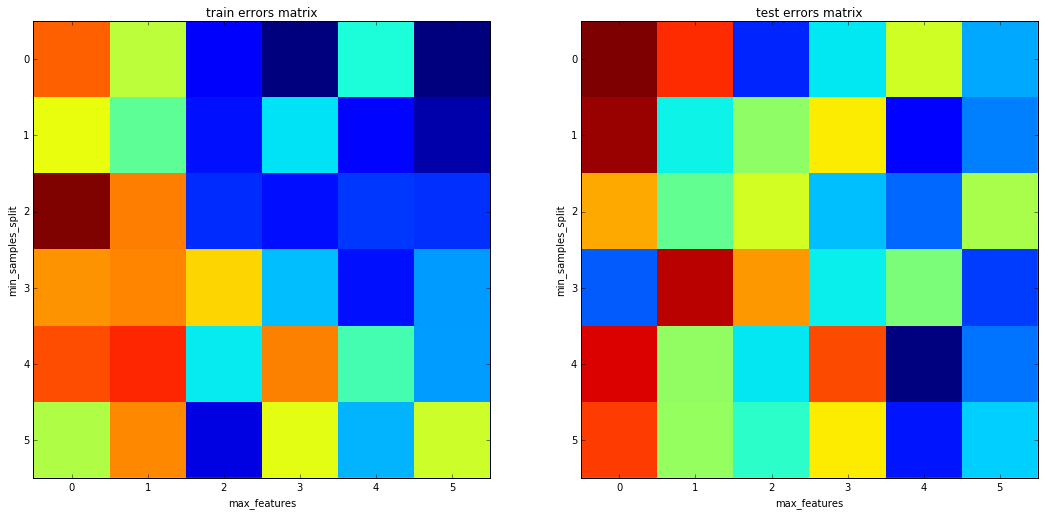

In [214]:
visualize_matrices(pandas.DataFrame.from_records(train_error_matrix_gbr),
                   pandas.DataFrame.from_records(test_error_matrix_gbr))

## Пункты 1-3 для XGBoost

In [60]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [61]:
params = {'max_depth':3, 'booster': 'gbtree'}

In [62]:
def xgboost_mse(model, sample, true_targets, num_boost_round): 
    return np.array([mean_squared_error(true_targets,
                                    model.predict(sample, ntree_limit=n + 1)) 
                     for n in range(num_boost_round)])

Обучим XGBoost на тренировочной выборке и для количеств деревьев от 1 до 250 посчитаем ошибку на тренировочной и тестовой выборках:

In [63]:
model = xgb.train(params, dtrain, num_boost_round=250)

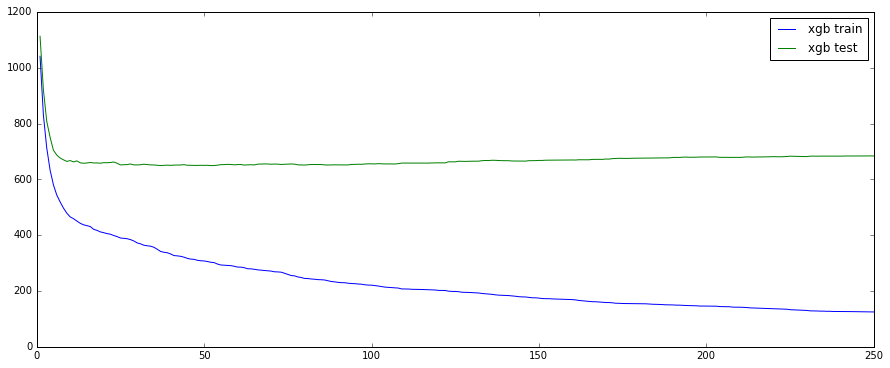

In [64]:
xgb_scores_train = xgboost_mse(model, dtrain, y_train, 250)
xgb_scores_test = xgboost_mse(model, dtest, y_test, 250)

plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(xgb_scores_train)) + 1, xgb_scores_train, label='xgb train')
plt.plot(np.arange(len(xgb_scores_test)) + 1, xgb_scores_test, label='xgb test')
plt.legend()
plt.show()

### Выводы:
Так же, как GradientBoosting из sklearn, xgboost переобучается на большом количестве деревьев

In [65]:
def prepare_features_xgb(model): 
    feature_names = xgb.Booster.get_fscore(model).keys()
    importances = xgb.Booster.get_fscore(model).items()

    for i in range(X_train.shape[1]):
        if 'f'+str(i) not in feature_names:
            importances.append(('f'+str(i), 0))
            
    importances = sorted(importances, key=lambda x: int(x[0][1:]))
    return [x[1] for x in importances]

xgb_feature_importances = prepare_features_xgb(model)

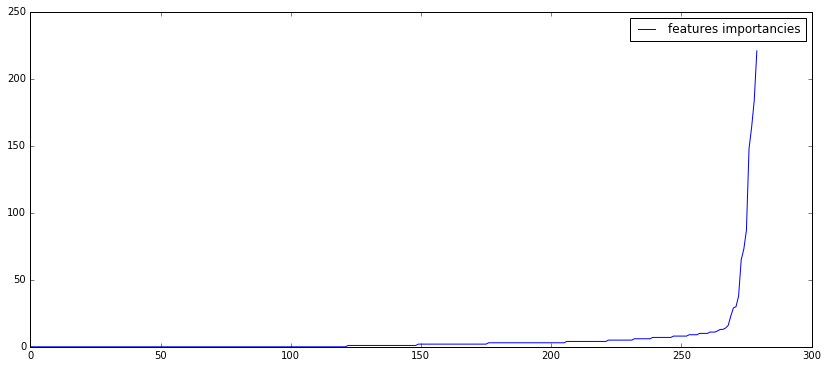

In [68]:
show_feature_importances(xgb_feature_importances)

In [69]:
important_features_indices_xgb = get_important_features(prepare_features_xgb(model))

X_train_less_features = X_train[:,important_features_indices_xgb]
X_test_less_features = X_test[:,important_features_indices_xgb]

In [70]:
pandas.DataFrame(important_features_indices_xgb).to_csv('important_features_indices_xgboost.csv')

In [71]:
dtrain_less_features = xgb.DMatrix(X_train_less_features, label=y_train)
dtest_less_features = xgb.DMatrix(X_test_less_features)

In [72]:
model_less_features = xgb.train(params, dtrain_less_features, num_boost_round=250)
xgb_scores_test_less_features = xgboost_mse(model_less_features, dtest_less_features, y_test, 250)

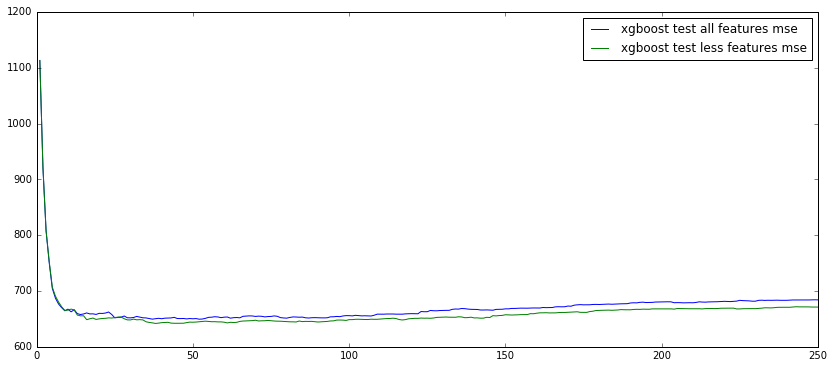

In [73]:
plt.figure(figsize=(14,6))
plt.plot(range(1, 251), xgb_scores_test, label='xgboost test all features mse')
plt.plot(range(1, 251), xgb_scores_test_less_features, label='xgboost test less features mse')
plt.legend(loc=1)

plt.show()

### Выводы:
Вот тут уже ошибка на всех признаках немного меньше, чем на only important

Подберем оптимальные значения параметров max_features и min_samples_split: Для каждой пары (max_features и min_samples_split) из сетки построим график ошибки прогноза на обучающей и на тестовой выборке в зависимости от количества деревьев. Будем для каждой пары параметров искать оптимальный num_boost_rounds: пока разность ошибок на на последней и 10-й с конца итерациях не станет < eps ,будем увеличивать num_boost_rounds. Возьмем eps=3

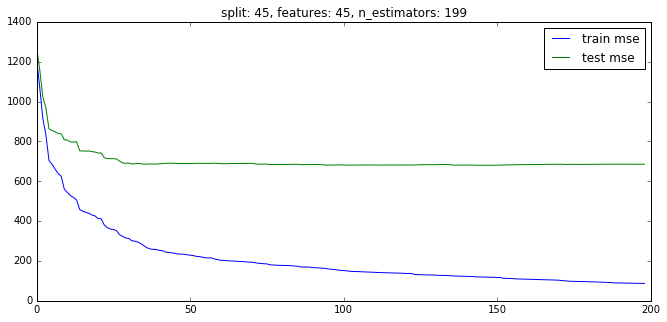

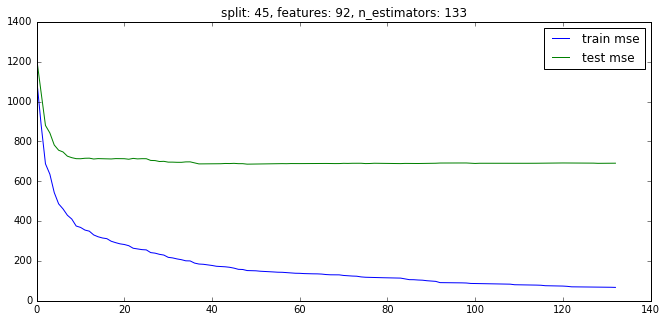

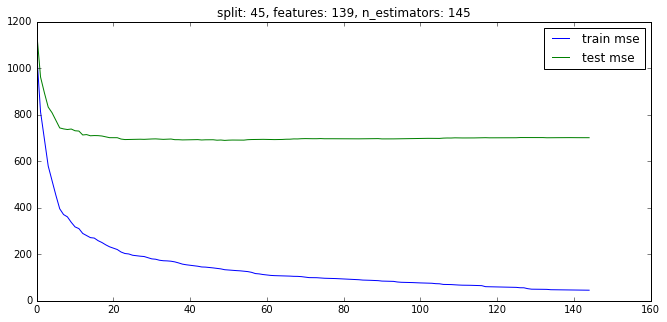

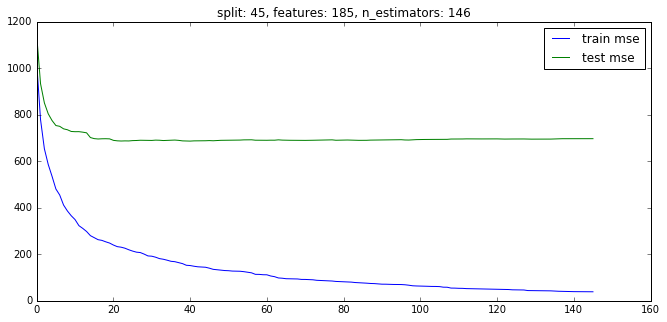

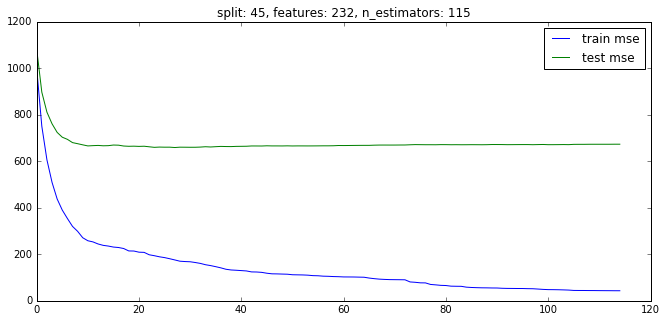

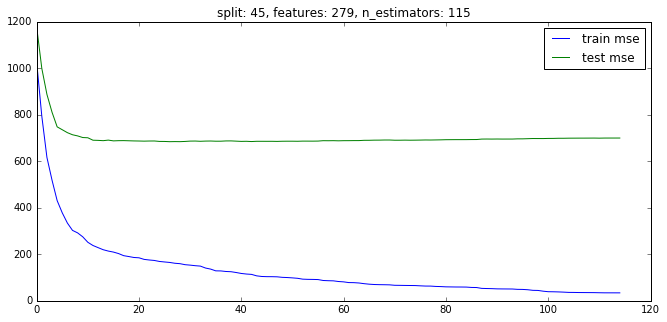

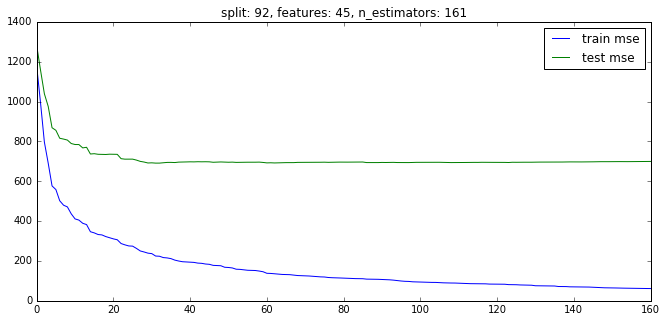

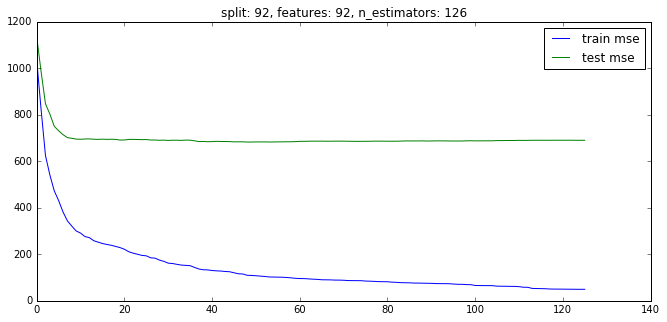

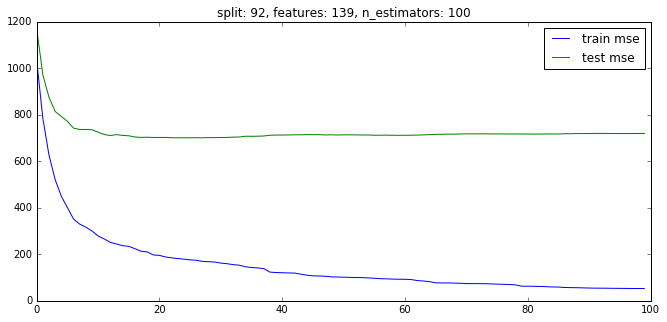

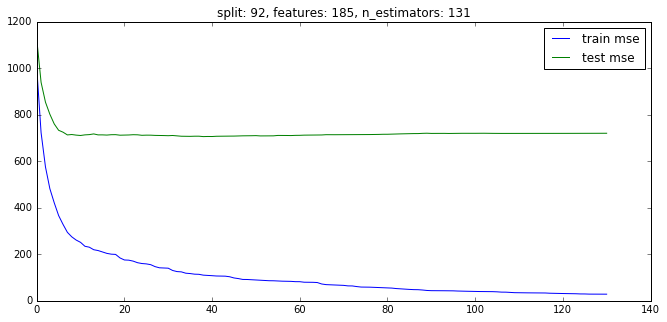

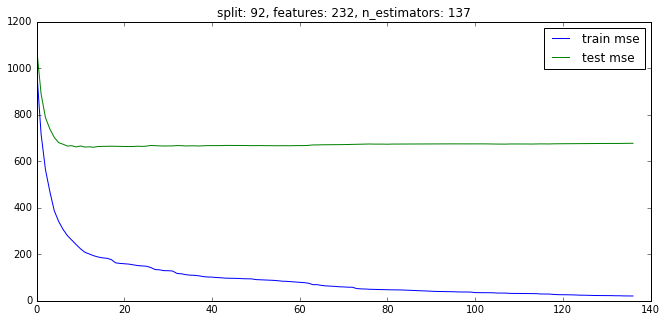

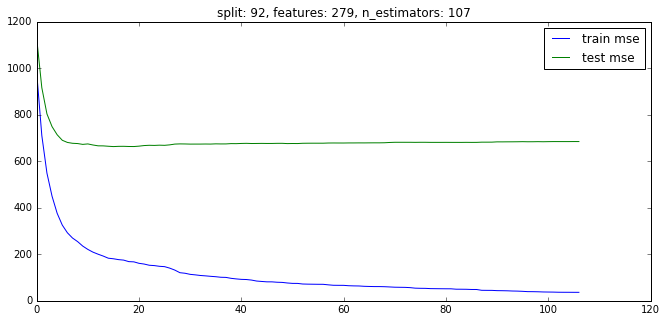

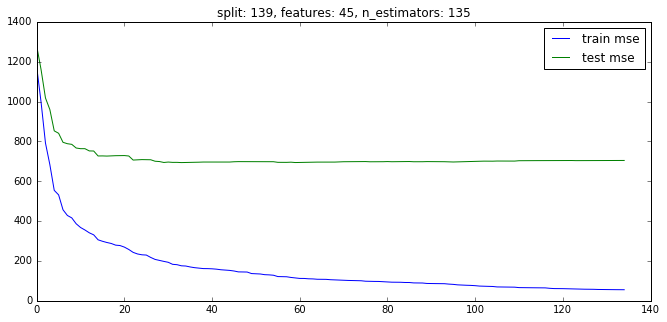

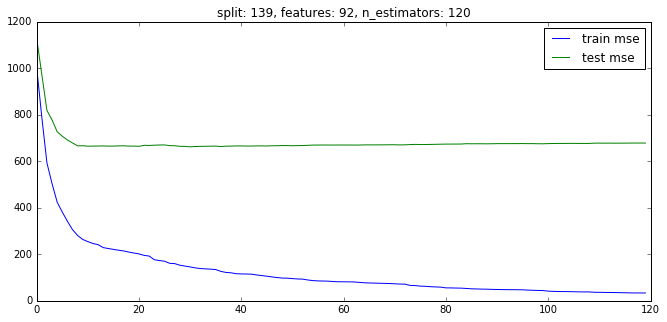

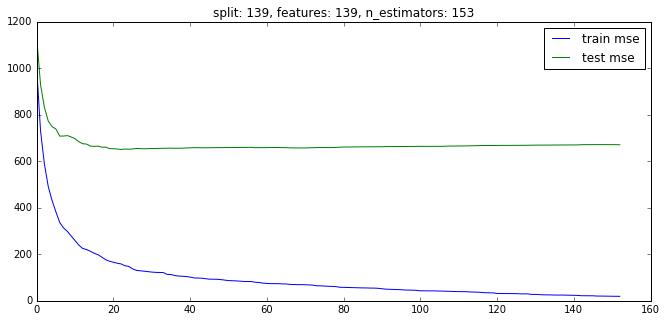

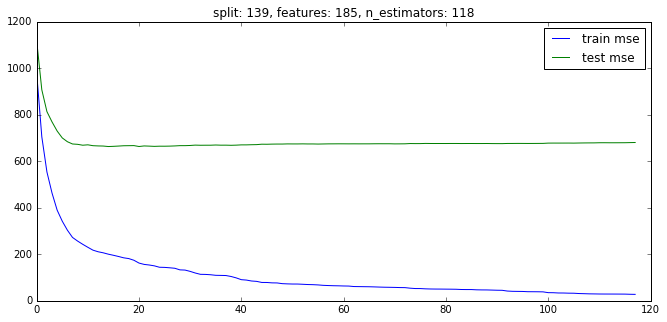

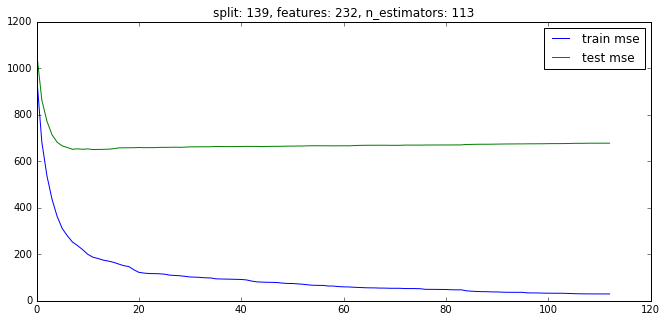

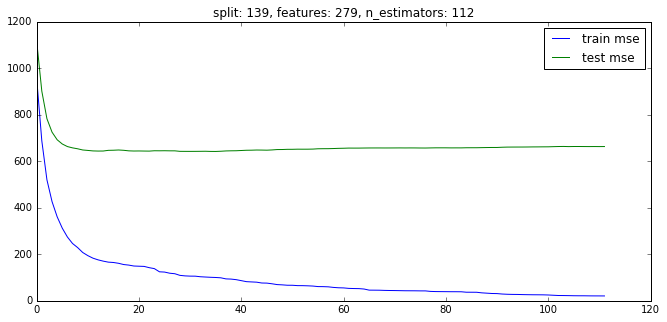

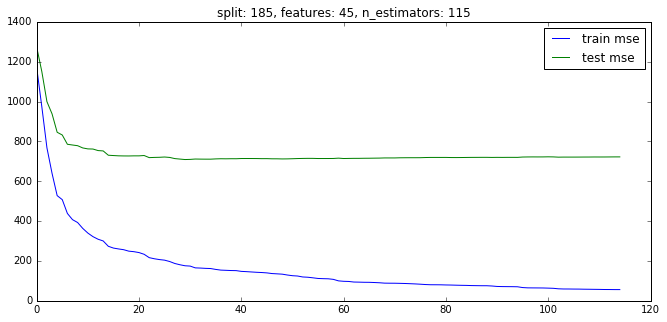

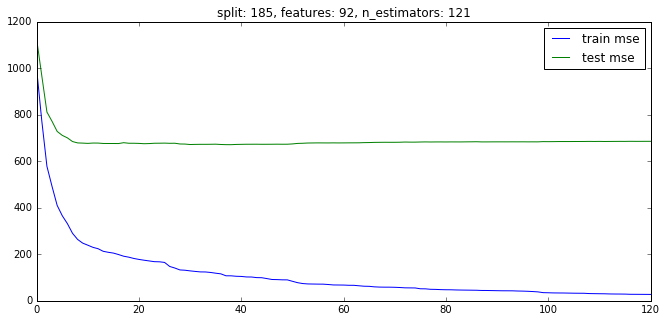

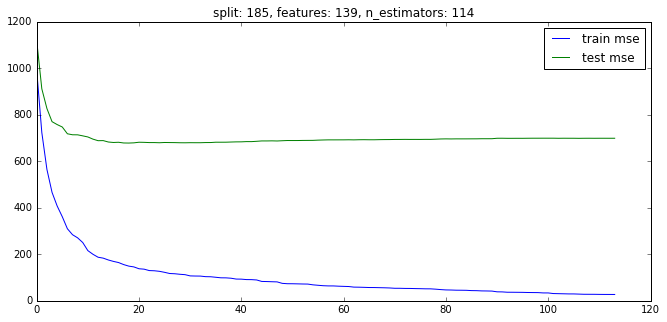

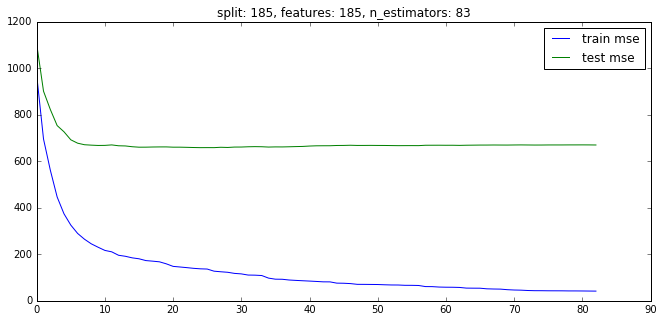

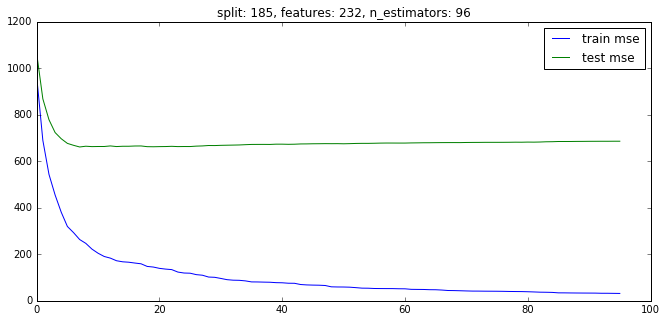

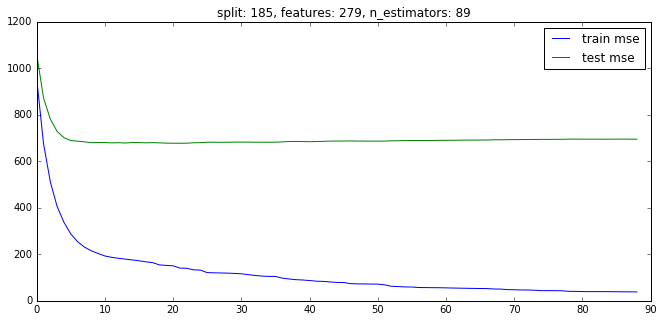

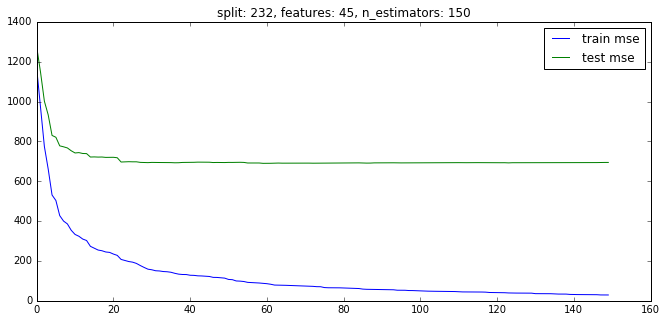

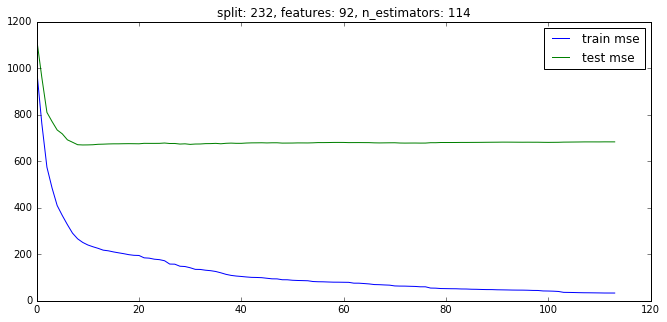

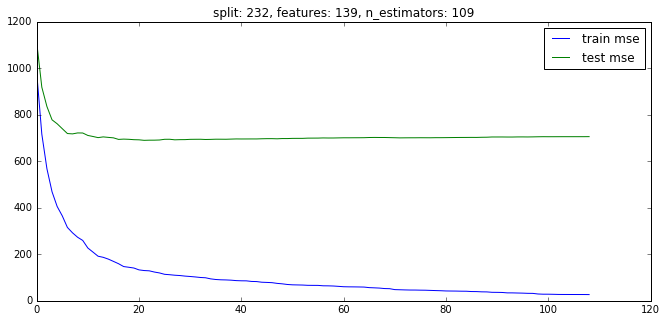

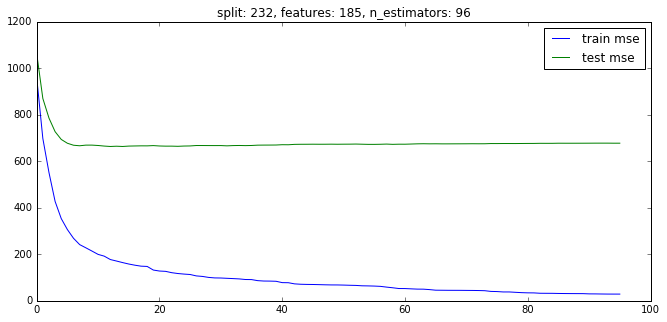

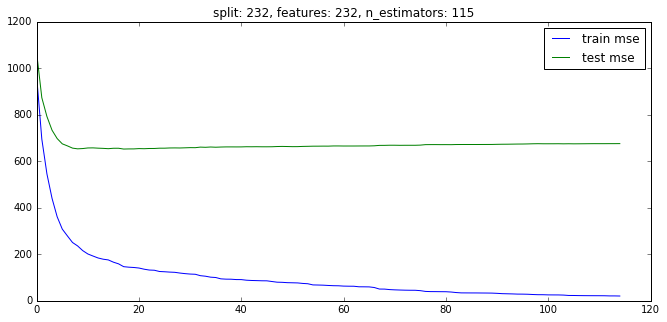

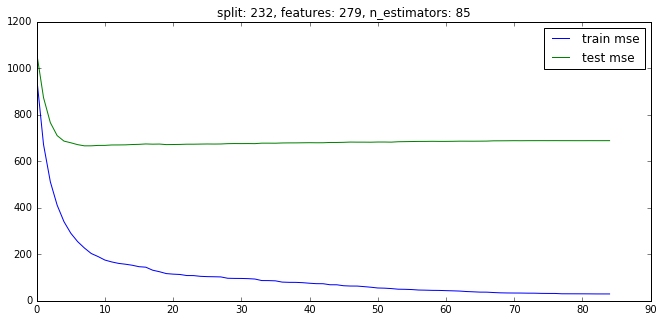

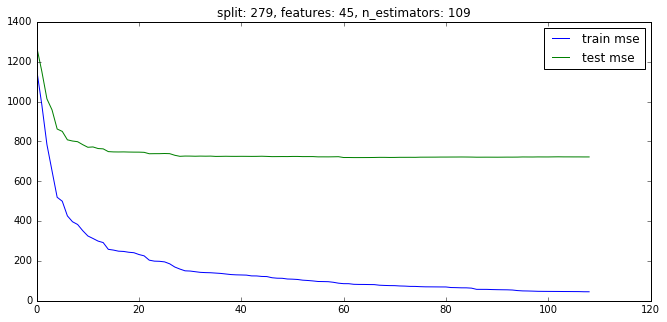

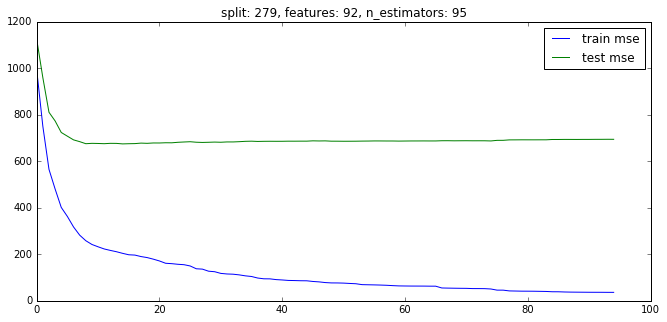

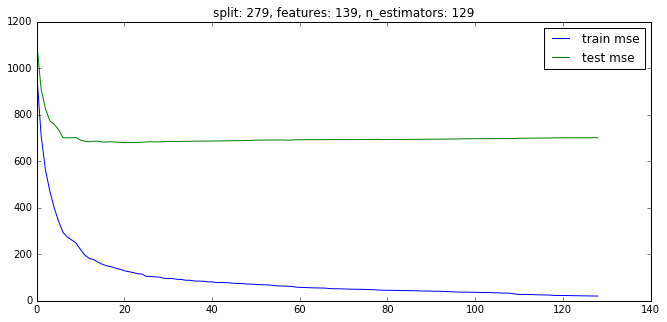

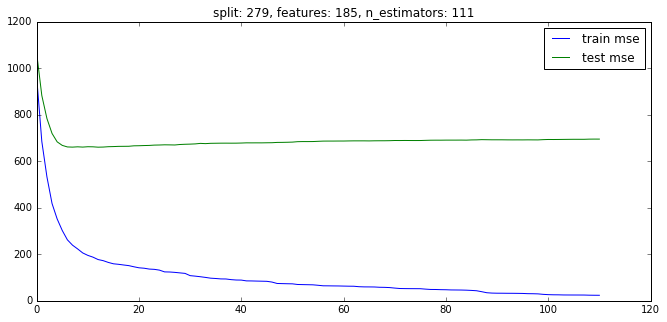

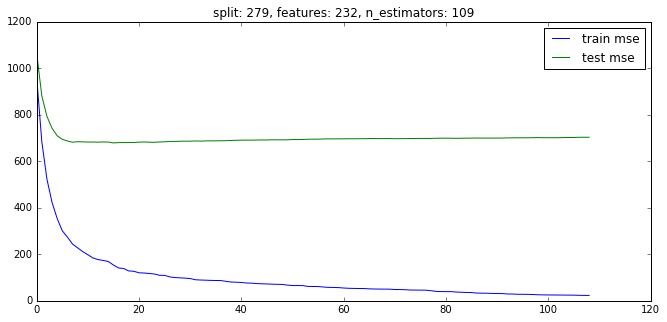

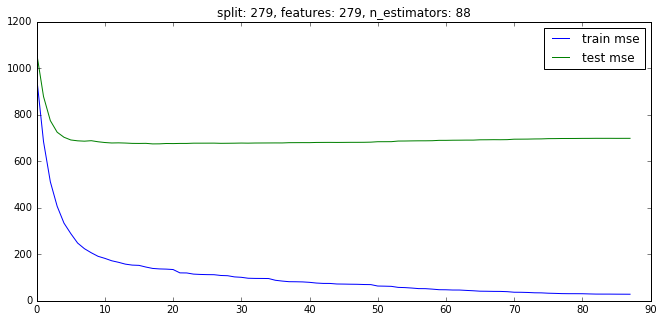

In [82]:
eps = 3

optimal_params_xgb = [[0 for i in range(6)] for j in range(6)]
train_error_matrix_xgb = [[0 for i in range(6)] for j in range(6)]
test_error_matrix_xgb = [[0 for i in range(6)] for j in range(6)]

param = {
    'booster': 'gbtree',
    'silent': 1
}

for min_samples_split in [int(280.0*i/6)-1 for i in range(1,7)]:
    for max_features in [int(280.0*i/6)-1 for i in range(1,7)]:
        param['colsample_bytree'] = float(max_features)/280.0
        param['colsample_bylevel'] = float(min_samples_split)/280.0
        
        clf = xgb.train(param, dtrain, 700)

        train_errors = []
        test_errors = []
        
        for i in range(700):
            train_errors.append(mean_squared_error(y_train, clf.predict(dtrain, ntree_limit=i + 1)))
            test_errors.append(mean_squared_error(y_test, clf.predict(dtest, ntree_limit=i + 1)))

            if len(train_errors) < 11:
                continue

            # see if mistake changed not much through last 10 iterations
            if abs(train_errors[-11] - train_errors[-1]) > eps:
                continue
                
            train_error_matrix_xgb[min_samples_split/40 - 1][max_features/40 - 1] = train_errors[-1]
            test_error_matrix_xgb[min_samples_split/40 - 1][max_features/40 - 1] = test_errors[-1]
            
            show_mse_errors(min_samples_split, max_features, i+1, train_errors, test_errors) 
            
            break

In [83]:
pandas.DataFrame.from_records(test_error_matrix_xgb)

,0,1,2,3,4,5
0,685.094195,690.474337,701.510523,697.343149,673.509337,700.081848
1,699.312307,690.351829,719.792280,720.634795,677.398139,684.923901
2,704.229343,678.499578,671.259537,680.846251,677.918087,663.490903
3,722.120645,685.926786,699.127780,670.166568,686.350192,695.193884
4,694.291875,683.591767,706.093993,677.889504,676.086329,688.823434
5,721.904795,694.575084,701.454952,695.461867,703.412872,698.797228


### Выводы:
Для xgboost разброс значений при разных значениях параметров сетки уже больше, чем у random forest и gradient boosting.

In [86]:
best_features_xgb = 279.0/X_train.shape[1]
best_split_xgb = 139.0/X_train.shape[1]
best_rounds_xgb = 112

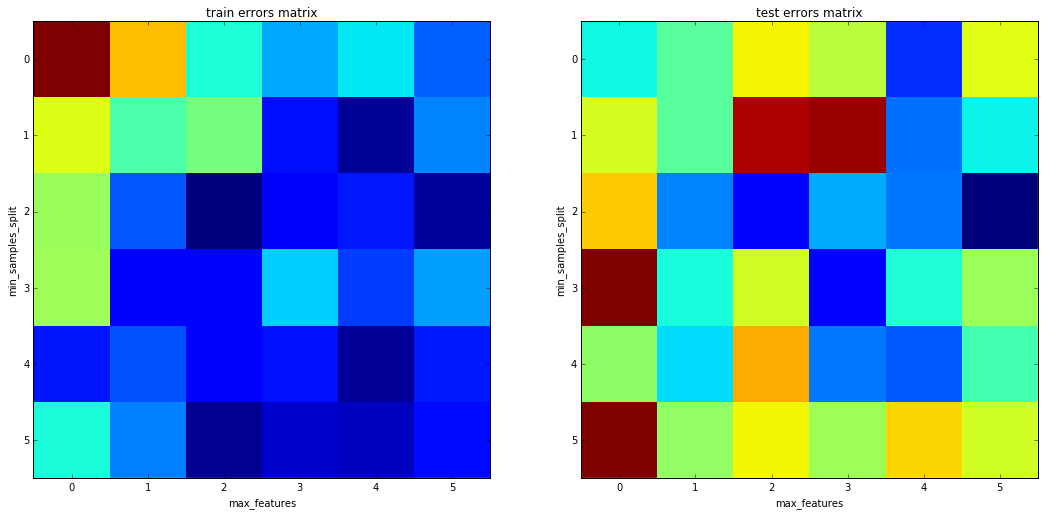

In [85]:
visualize_matrices(pandas.DataFrame.from_records(train_error_matrix_xgb),
                   pandas.DataFrame.from_records(test_error_matrix_xgb))

## Пункт 5

Сравними RF, GB и XGB по времени работы:

In [87]:
rfr = RandomForestRegressor(max_features=best_features_rfr, min_samples_split=best_split_rfr, 
                            n_estimators=best_estimators_rfr)
print "RandomForest: "
%time rfr.fit(X_train, y_train)

gbr = GradientBoostingRegressor(max_features=best_features_gbr, min_samples_split=best_split_gbr, 
                            n_estimators=best_estimators_gbr)
print "GradientBoosting: "
%time gbr.fit(X_train, y_train)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {'booster': 'gbtree', 'colsample_bytree': best_features_xgb, 
          'colsample_bylevel': best_split_xgb}
print "XGboost: "
%time clf = xgb.train(params, dtrain, num_boost_round=best_rounds_xgb)

RandomForest: 
CPU times: user 1min 5s, sys: 20 ms, total: 1min 5s
Wall time: 1min 5s
GradientBoosting: 
CPU times: user 30.1 s, sys: 4 ms, total: 30.1 s
Wall time: 30.1 s
XGboost: 
CPU times: user 6.13 s, sys: 48 ms, total: 6.18 s
Wall time: 1.66 s


..и по ошибкам на тесте:

In [92]:
rfr_pred = rfr.predict(X_test)
print "Random Forest test mse:", mean_squared_error(rfr_pred, y_test)

gbr_pred = gbr.predict(X_test)
print "GradientBoosting mse:", mean_squared_error(gbr_pred, y_test)

xgb_pred = clf.predict(dtest)
print "XGBoost mse:", mean_squared_error(xgb_pred, y_test)

Random Forest test mse: 618.095345138
GradientBoosting mse: 641.467947013
XGBoost mse: 663.490902741


### Выводы:
RandomForest и GradientBoosting показали лучший результат по сравнению с XGBoost'ом. Это, скорее всего, связано с тем, что для разных моделей мы брали разные eps, хотя по графикам видно, что ошибка на train для этих eps стабилизировалась

Выделим у трех взятых классификаторов главные признаки и посмотрим на время работы и качество классификации их на важных признаках:

In [94]:
important_features_indices_rfr = get_important_features(rfr.feature_importances_)
X_train_less_features_rfr = X_train[:,important_features_indices_rfr]
X_test_less_features_rfr = X_test[:,important_features_indices_rfr]

rfr_less = RandomForestRegressor(n_estimators=best_estimators_rfr)
print "RandomForest with less features: "
%time rfr_less.fit(X_train_less_features_rfr, y_train)

important_features_indices_gbr = get_important_features(gbr.feature_importances_)
X_train_less_features_gbr = X_train[:,important_features_indices_gbr]
X_test_less_features_gbr = X_test[:,important_features_indices_gbr]

gbr_less = GradientBoostingRegressor(n_estimators=best_estimators_gbr)
print "GradientBoosting with less features: "
%time gbr_less.fit(X_train_less_features_gbr, y_train)

important_features_indices_xgb = get_important_features(prepare_features_xgb(clf))
X_train_less_features_xgb = X_train[:,important_features_indices_xgb]
X_test_less_features_xgb = X_test[:,important_features_indices_xgb]

dtrain_less_features = xgb.DMatrix(X_train_less_features_xgb, label=y_train)
dtest_less_features = xgb.DMatrix(X_test_less_features_xgb)

print "XGBoost with less features: "
%time clf = xgb.train(params, dtrain_less_features, num_boost_round=best_rounds_xgb)

RandomForest with less features: 
CPU times: user 38.7 s, sys: 8 ms, total: 38.7 s
Wall time: 38.7 s
GradientBoosting with less features: 
CPU times: user 4.52 s, sys: 0 ns, total: 4.52 s
Wall time: 4.52 s
XGBoost with less features: 
CPU times: user 5.3 s, sys: 80 ms, total: 5.38 s
Wall time: 1.43 s


In [99]:
rfr_less_pred = rfr_less.predict(X_test_less_features_rfr)
print "Random Forest with less features test mse:", mean_squared_error(rfr_less_pred, y_test)

gbr_less_pred = gbr_less.predict(X_test_less_features_gbr)
print "GradientBoosting with less features test mse:", mean_squared_error(gbr_less_pred, y_test)

xgb_less_pred = clf.predict(dtest_less_features)
print "XGBoost with less features test mse:", mean_squared_error(xgb_less_pred, y_test)

Random Forest with less features test mse: 625.727982638
GradientBoosting with less features test mse: 639.415748346
XGBoost with less features test mse: 689.82778637


### Выводы:
Как видно, если брать только важные признаки, время работы уменьается (у GradientBoosting так вообще заметно), но ошибка увеличивается, особенно у XGBoost

## Пункт 6

Обучим лучшие модели на 1000 деревьев и посмотрим на ошибки на train и на test:

/home/tatiana/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Best n_estimators is: 529
corresponding mse 618.91546991


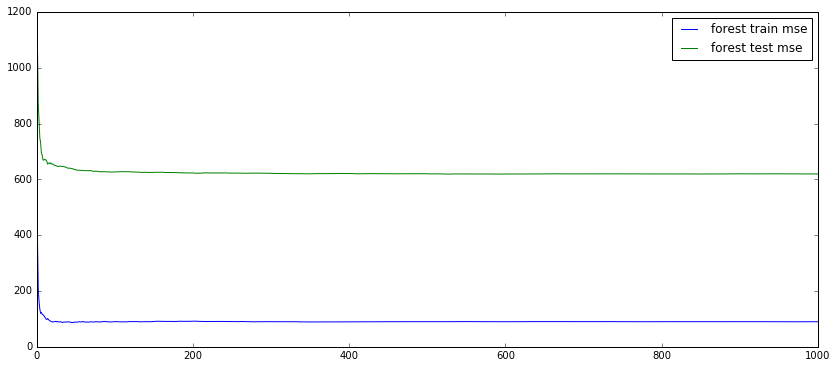

In [173]:
rfr_1000 = RandomForestRegressor(max_features=best_features_rfr, min_samples_split=best_split_rfr, 
                                 oob_score=True, warm_start=True)    
forest_errors_train, forest_errors_test, oob_train_score_mse = process_rfr(rfr_1000, 1000)

best_estimators_rfr = np.argmin(forest_errors_test)
print 'Best n_estimators is:', best_estimators_rfr
print 'corresponding mse', min(forest_errors_test)

plt.figure(figsize=(14,6))
plt.plot(range(1, 1001), forest_errors_train, label='forest train mse')
plt.plot(range(1, 1001), forest_errors_test, label='forest test mse')

plt.legend(loc=1)

plt.show()

Best n_estimators is: 155
corresponding mse 634.109109498


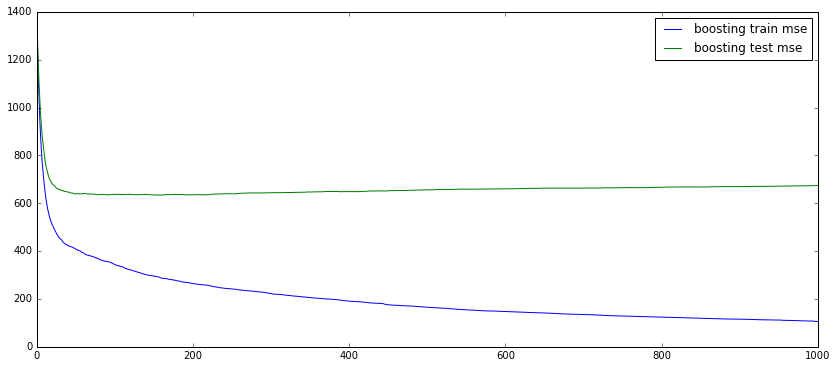

In [174]:
gbr_1000 = GradientBoostingRegressor(max_features=best_features_gbr, min_samples_split=best_split_gbr, 
                                      warm_start=True)    
boosting_errors_train, boosting_errors_test = process_gbr(gbr_1000, 1000)

best_estimators_gbr = np.argmin(boosting_errors_test)
print 'Best n_estimators is:', best_estimators_gbr
print 'corresponding mse', min(boosting_errors_test)

plt.figure(figsize=(14,6))
plt.plot(range(1, 1001), boosting_errors_train, label='boosting train mse')
plt.plot(range(1, 1001), boosting_errors_test, label='boosting test mse')

plt.legend(loc=1)

plt.show()

Best n_estimators is: 35
corresponding mse 642.367311573


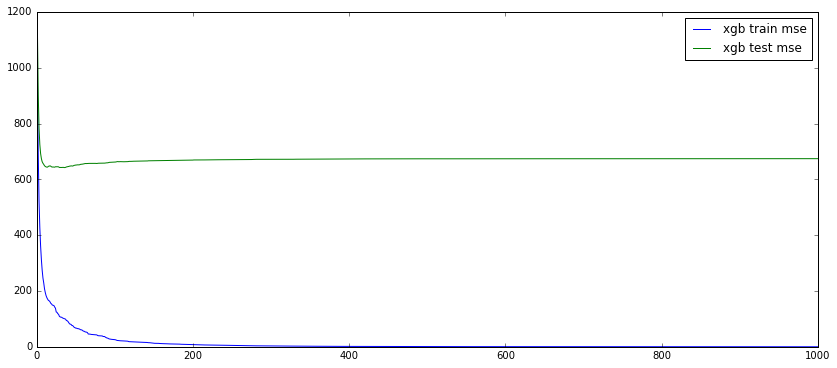

In [175]:
clf_1000 = xgb.train(params, dtrain, 1000)
xgb_errors_train = xgboost_mse(clf_1000, dtrain, y_train, 1000)
xgb_errors_test = xgboost_mse(clf_1000, dtest, y_test, 1000)

best_rounds_xgb = np.argmin(xgb_errors_test)
print 'Best n_estimators is:', best_rounds_xgb
print 'corresponding mse', min(xgb_errors_test)

plt.figure(figsize=(14,6))
plt.plot(range(1, 1001), xgb_errors_train, label='xgb train mse')
plt.plot(range(1, 1001), xgb_errors_test, label='xgb test mse')

plt.legend(loc=1)

plt.show()

### Выводы:
При большом количестве деревьев GradientBoosting и XGBoost переобучаются -- ошибка на train падает, а на test растет. RandomForest на 1000 деревьев не переобучился, более того, ошибка и на train, и на test стала постоянной при количестве деревьев > 40.

## Пункт 7

Возьмем лучшую модель из предыдущего пункта и попробуем обучать XGBoost на ее ошибки:

In [25]:
rfr = RandomForestRegressor(n_estimators=529, max_features=best_features_rfr, min_samples_split=best_split_rfr)   
rfr.fit(X_train, y_train)


y_rfr_pred_train = rfr.predict(X_train)
y_rfr_pred_test = rfr.predict(X_test)

print "RF test mse:", mean_squared_error(y_rfr_pred_test, y_test)

RF test mse: 660.054161135


In [22]:
y = y_train - y_rfr_pred_train
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)

clf = xgb.train({'booster': 'gbtree'}, dtrain, num_boost_round=500)

Best n is: 7
corresponding mse 657.160504453


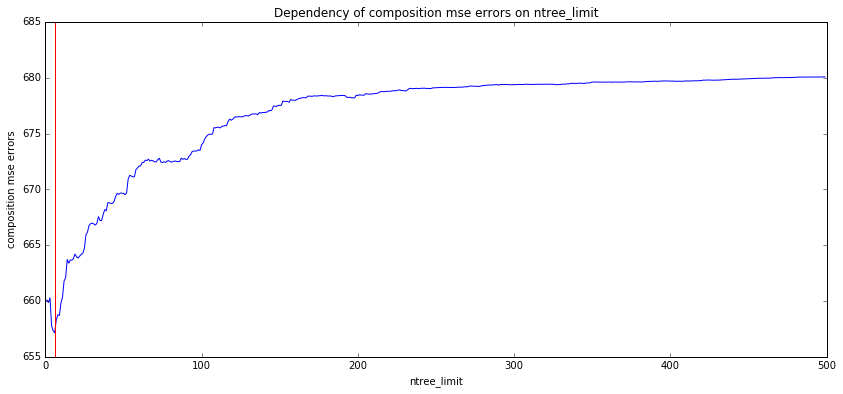

In [24]:
composition_errors = np.array([mean_squared_error(clf.predict(dtest, ntree_limit=n+1)+y_rfr_pred_test, y_test) 
                               for n in range(500)])

best_n = np.argmin(composition_errors)
print 'Best n is:', best_n+1
print 'corresponding mse', min(composition_errors)

plt.figure(figsize=(14, 6))
plt.plot(range(500), composition_errors)

plt.xlabel('ntree_limit')
plt.ylabel('composition mse errors')
plt.title('Dependency of composition mse errors on ntree_limit')

plt.axvline(x=best_n, color='r')

plt.show()

Сделаем то же самое с начальным приближением линейной регрессией:

In [27]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge()
ridge.fit(X_train, y_train)

y_ridge_pred_train = ridge.predict(X_train)
y_ridge_pred_test = ridge.predict(X_test)

print "Ridge test mse:", mean_squared_error(ridge.predict(X_test), y_test)

Ridge test mse: 970.067533514


In [28]:
y = y_train - y_ridge_pred_train
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)

clf = xgb.train({'booster': 'gbtree'}, dtrain, num_boost_round=500)

Best n is: 13
corresponding mse 688.563507729


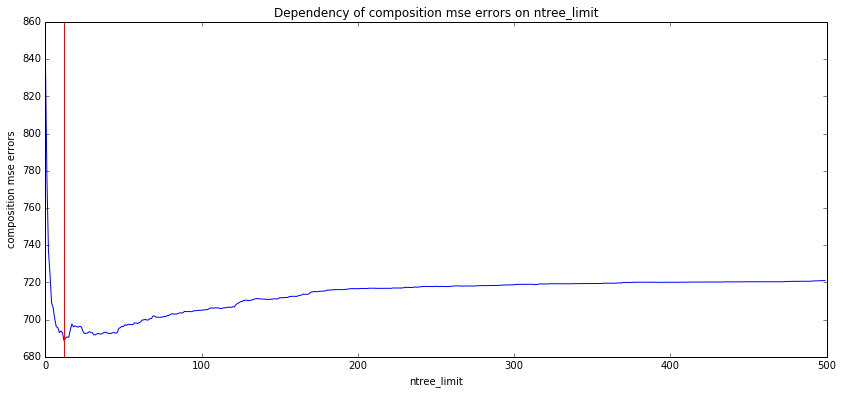

In [29]:
composition_errors = np.array([mean_squared_error(clf.predict(dtest, ntree_limit=n+1)+y_ridge_pred_test, y_test) 
                               for n in range(500)])

best_n = np.argmin(composition_errors)
print 'Best n is:', best_n+1
print 'corresponding mse', min(composition_errors)

plt.figure(figsize=(14, 6))
plt.plot(range(500), composition_errors)

plt.xlabel('ntree_limit')
plt.ylabel('composition mse errors')
plt.title('Dependency of composition mse errors on ntree_limit')

plt.axvline(x=best_n, color='r')

plt.show()

## Выводы:
В случае начального приближения RandomForest малое оптимальное количество деревьев XGBoost объясняется тем, что запуская RandomForest на лучших параметрах, мы уже "подобрали" оптимальное количество деревьев и xgboost'у не нужно исправлять много ошибок RandomForest.

В случае Ridge количество деревьев также небольшое, что может говорить о том, что Ridge также приближает ответ не так плохо, поэтому xgboost'у надо исправлять не так много ошибок. Однако по графику xgboost над Ridge, в отличие от RandomForest, видно, что при малых значениях num_boost_rounds xgboost'а ошибка большая. Это говорит о том, что  композицию Ridge+XGBoost применять более обоснованно, xgboost действительно улучшает качество Ridge.

## Пункт 8

Посмотрим на композиции с RandomForest и GradientBoosting c Ridge:

In [165]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge()
ridge.fit(X_train, y_train)

print "Ridge train mse error:", mean_squared_error(ridge.predict(X_train), y_train)
print "Ridge test mse error:", mean_squared_error(ridge.predict(X_test), y_test)

Ridge train mse error: 861.073646036
Ridge test mse error: 948.480462791


RandomForest:

In [166]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

print "RandomForest train mse error:", mean_squared_error(rfr.predict(X_train), y_train)
print "RandomForest test mse error:", mean_squared_error(rfr.predict(X_test), y_test)

RandomForest train mse error: 121.784059792
RandomForest test mse error: 686.954309458


Подберем оптимальное alpha для композиции RandomForest и LinearRegression:

In [167]:
ridge_pred = ridge.predict(X_test)
rfr_pred = rfr.predict(X_test)
    
composition_mse_errors = np.array([mean_squared_error(y_test, alpha * ridge_pred + (1 - alpha) * rfr_pred) 
                     for alpha in [float(i)/100 for i in range(101)]])

best_alpha_rfr_lr = np.argmin(composition_mse_errors) / 100.0
print 'Best alpha is:', best_alpha_rfr_lr
print 'corresponding mse', min(composition_mse_errors)

Best alpha is: 0.21
corresponding mse 667.698506451


График зависимости ошибки mse композиции от alpha:

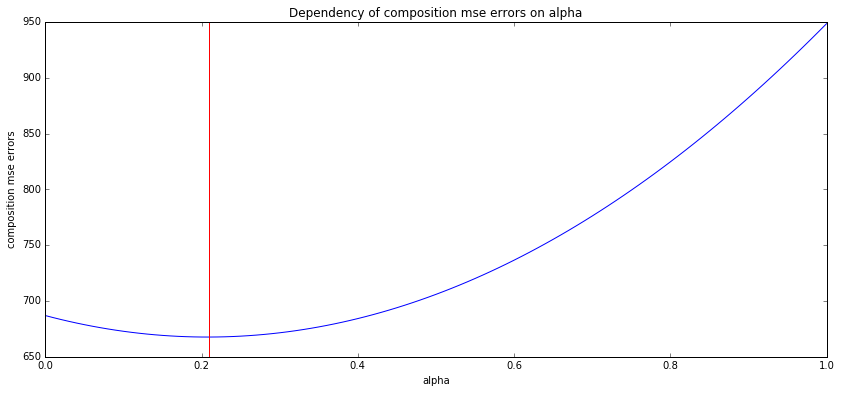

In [169]:
plt.figure(figsize=(14, 6))
plt.plot([float(i)/100 for i in range(101)], composition_mse_errors)

plt.xlabel('alpha')
plt.ylabel('composition mse errors')
plt.title('Dependency of composition mse errors on alpha')

plt.axvline(x=best_alpha_rfr_lr, color='r')

plt.show()

GradientBoosting:

In [142]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

print "GradientBoosting train mse error:", mean_squared_error(gbr.predict(X_train), y_train)
print "GradentBoosting test mse error:", mean_squared_error(gbr.predict(X_test), y_test)

GradientBoosting train mse error: 322.382783462
GradentBoosting test mse error: 631.693481513


Подберем оптимальное alpha для композиции GradientBoosting и LinearRegression:

In [161]:
ridge_pred = ridge.predict(X_test)
gbr_pred = gbr.predict(X_test)
    
composition_mse_errors = np.array([mean_squared_error(y_test, alpha * ridge_pred + (1 - alpha) * gbr_pred) 
                     for alpha in [float(i)/100 for i in range(101)]])

best_alpha_gbr = np.argmin(composition_mse_errors) / 100.0
print 'Best alpha is:', best_alpha_gbr
print 'corresponding mse', min(composition_mse_errors)

Best alpha is: 0.01
corresponding mse 631.650069902


График зависимости ошибки mse композиции от alpha:

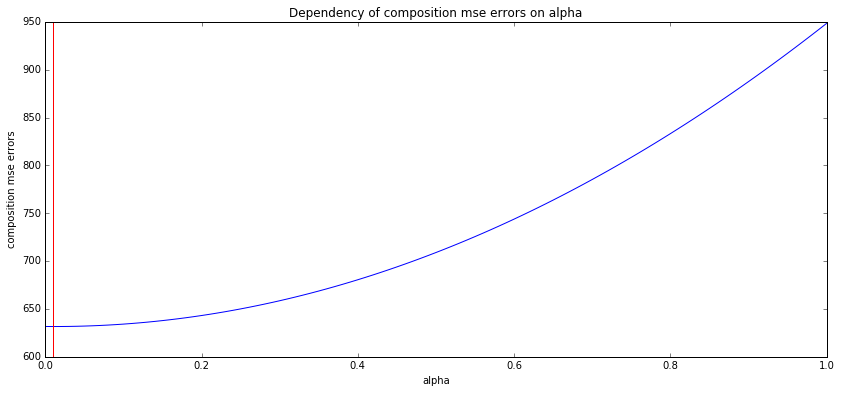

In [162]:
plt.figure(figsize=(14, 6))
plt.plot([float(i)/100 for i in range(101)], composition_mse_errors)

plt.xlabel('alpha')
plt.ylabel('composition mse errors')
plt.title('Dependency of composition mse errors on alpha')

plt.axvline(x=best_alpha_gbr, color='r')

plt.show()

## Выводы:
Композиция GBR и LR дала лучший score, чем RF и LR. Однако в обоих случаях лучший score композиции достигался не при alpha=0 или 1, что говорит о том, что комбинирование моделей может дать результат лучше, чем одна модель.

Также композиция GBR и LR дала лучший score, чем композиции из предыдущего пункта, RF и LR -- немного хуже, чем одна из композиций из предыдущего пункта и лучше, чем вторая. Это говорит о том, что, вероятно, использование смеси композиций с правильно подобранным коэффициентом дает лучший результат, чем "исправление ошибок" одного классификатора другим.